# Define dataset and Initital Scaling

In [1]:
%matplotlib inline

In [60]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pylab as pl
from IPython import display


In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()

In [4]:
def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)

In [62]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}
print(Current_min, Current_max)

-0.000520787 6.74372


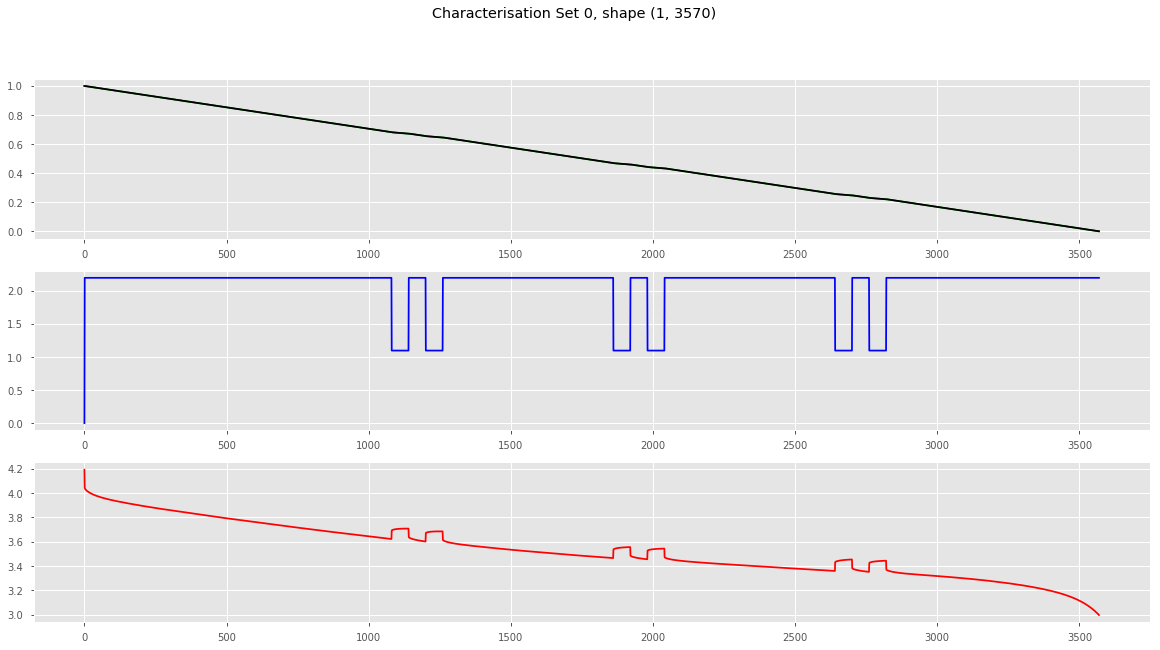

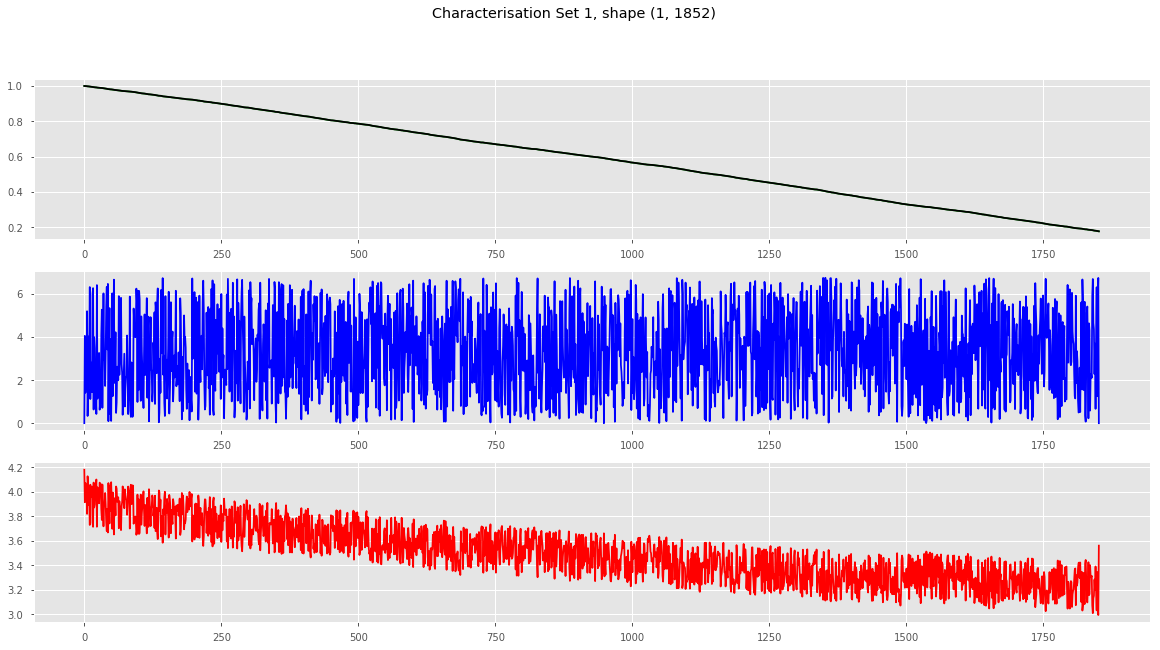

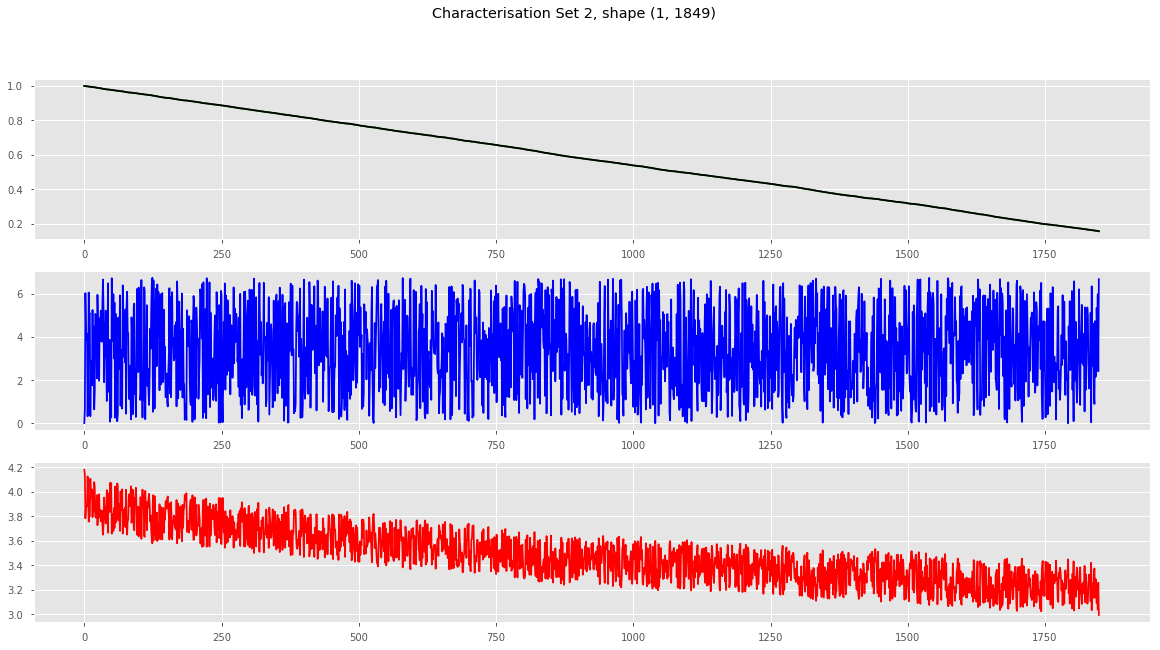

In [6]:
for i, set_dict in enumerate(Characterisation_Set['Sets']):
    matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.figure()
    plt.suptitle("Characterisation Set {}, shape {}".format(i, set_dict['SoC'].shape))
    plt.subplot(311)
    plt.plot(set_dict['SoC'].T, '-g')
    Characterisation_Set['Sets'][i]['SoC_prior'] = np.array(np.concatenate(([1.0], set_dict['SoC'][0, :-1]), axis=0), ndmin=2)
    plt.plot(Characterisation_Set['Sets'][i]['SoC_prior'].T, '-k')
    plt.subplot(312)
    plt.plot(set_dict['Current'].T, '-b')
    Characterisation_Set['Sets'][i]['Current_prior'] = np.array(np.concatenate(([set_dict['Current'][0, 0]], set_dict['Current'][0, :-1]), axis=0), ndmin=2)
    plt.subplot(313)
    plt.plot(set_dict['Voltage'].T, '-r')
    plt.show()

## 2. Train RNN from Prior

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN_Network(nn.Module):
    def __init__(self):
        super(RNN_Network, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
    
    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))


    def forward(self, soc_prior, current_prior, current):
        
        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        V = self.VoC(soc) - I * Z

        # Predict SoC(t-1) -> SoC(t)
        soc = soc - I*V/Characterisation_Set['E_crit']

        # Bounds
        max_test = soc[:, 0] > 1.0
        soc[max_test, 0] = 1.0
        min_test = soc[:, 0] < 0.0
        soc[min_test, 0] = 0.0000000001

        # Posterior Evidence
        if current.shape[1] == 1:
            I = torch.from_numpy(current).to(device, torch.float)
        else:
            I = torch.from_numpy(current.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # a Priori evidence
        V = self.VoC(soc) - I*Z

        return V, soc

In [8]:
save_network = "./Battery_Data/new_battery_cycles/Battery_RNN_GT_new_v2.mdl"

In [9]:
rnn = RNN_Network()
# init
for W in rnn.parameters():
    nn.init.normal_(W)

In [10]:
rnn.to(device)

RNN_Network(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
)

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(rnn.parameters()) 

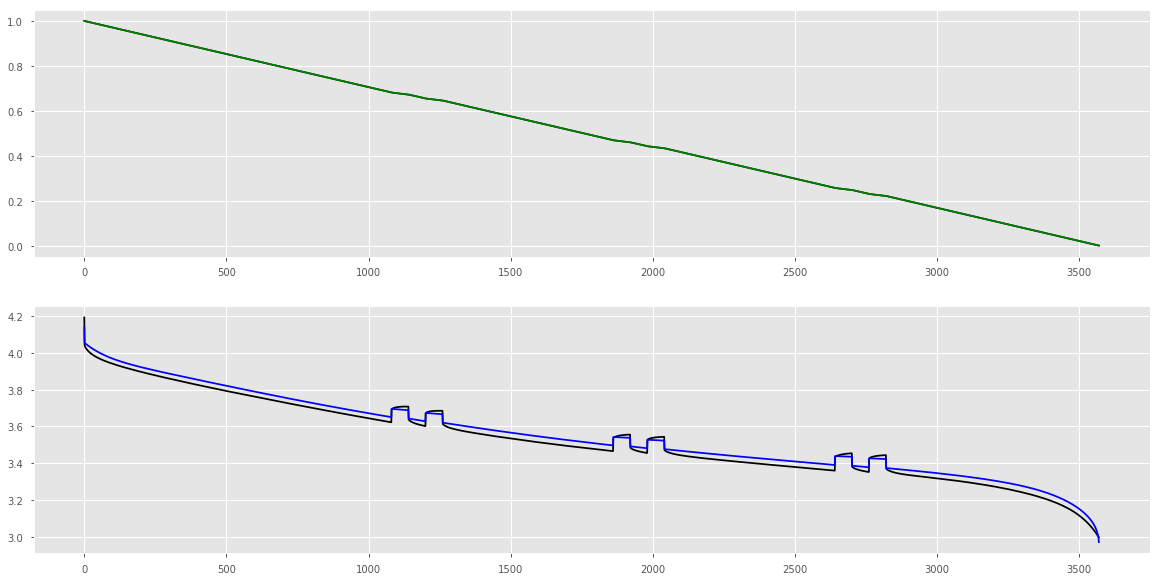

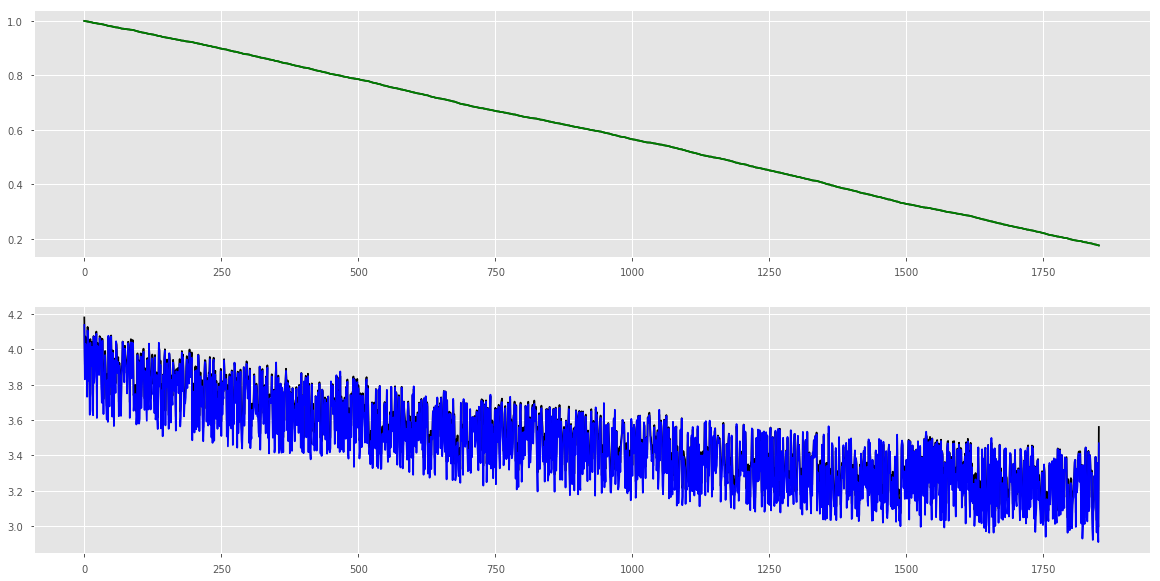

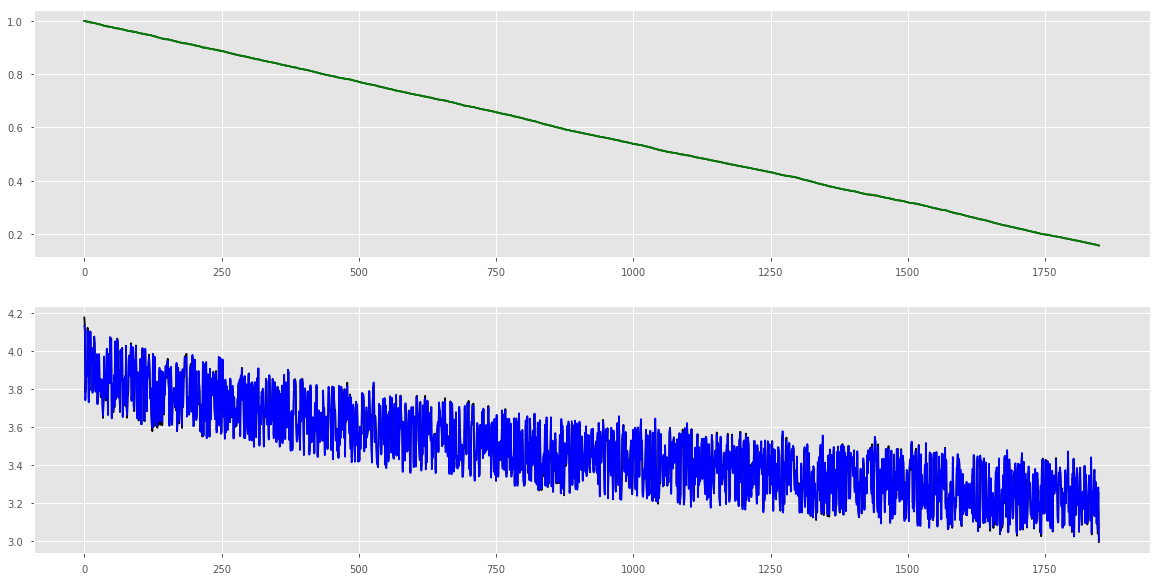

epoch 0, time since start: 0m 0s, estimated remaining time: 6h 8m 20s
New average minimum: 0.0021016781975049525
New average minimum: 0.0018047375488094985
New average minimum: 0.0013213001172213505
New average minimum: 0.0008567714442809423
New average minimum: 0.0005369254067772999
New average minimum: 0.00034770289494190365
New average minimum: 0.00025389114550004405
New average minimum: 0.00022518705615463355
New average minimum: 0.00017657013571200272
New average minimum: 0.00015600798360537738
New average minimum: 0.0001507208119922628
New average minimum: 0.00013876016600988805
New average minimum: 0.00013225874135969207


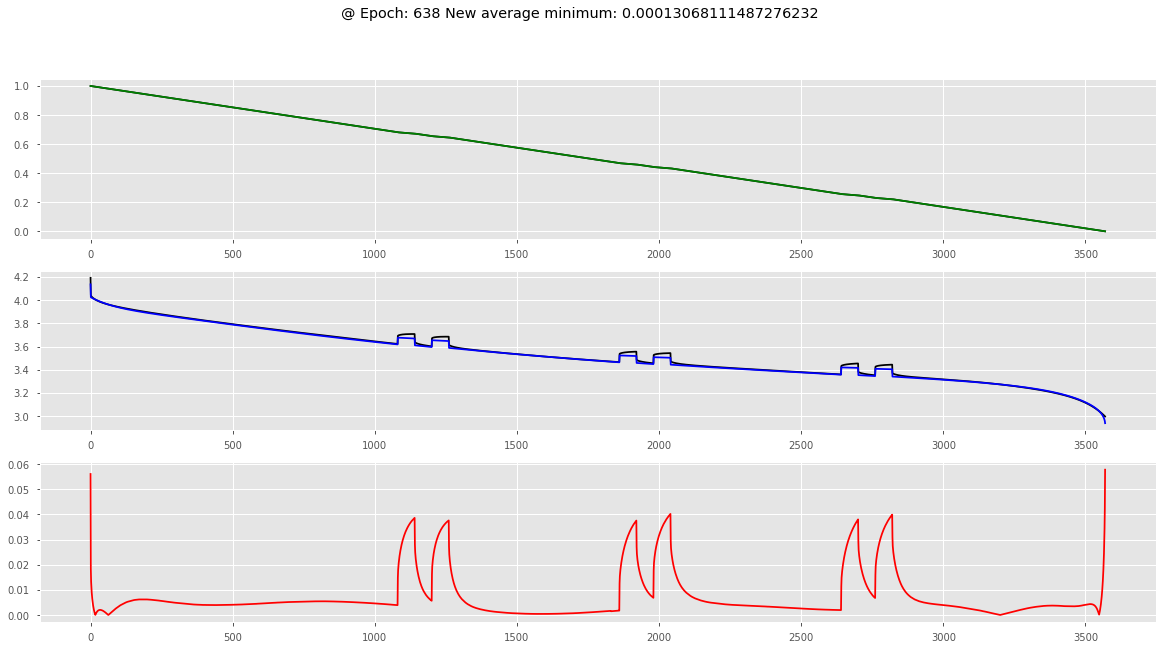

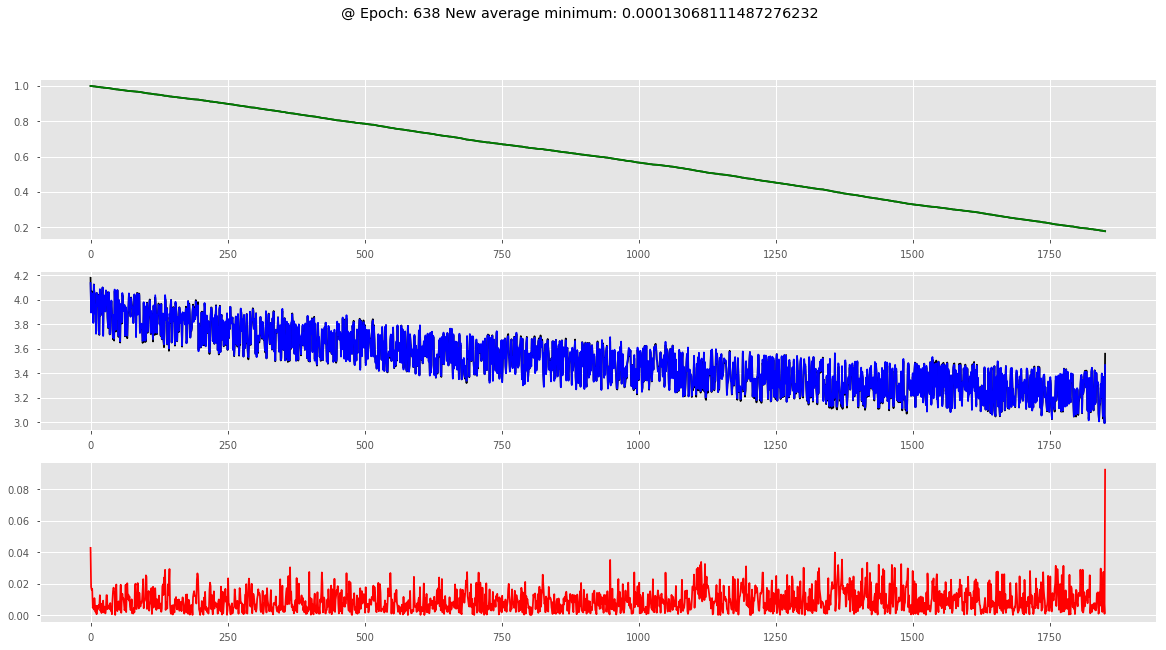

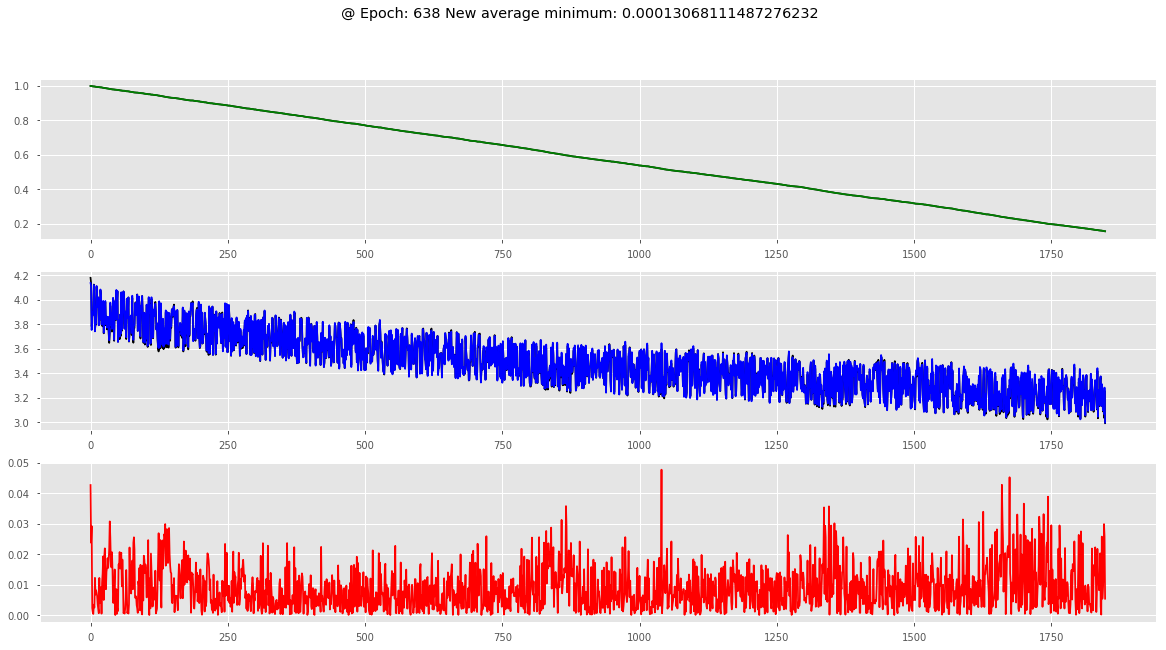

New average minimum: 0.00012930248097594207
epoch 1000, time since start: 0m 22s, estimated remaining time: 0h 9m 9s


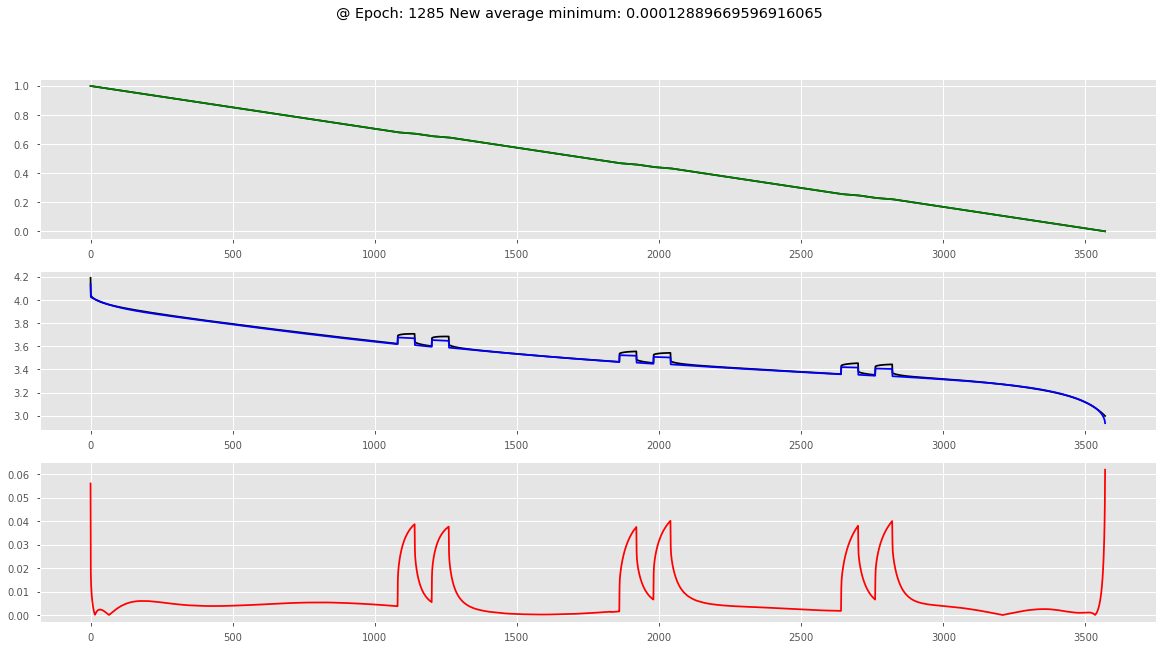

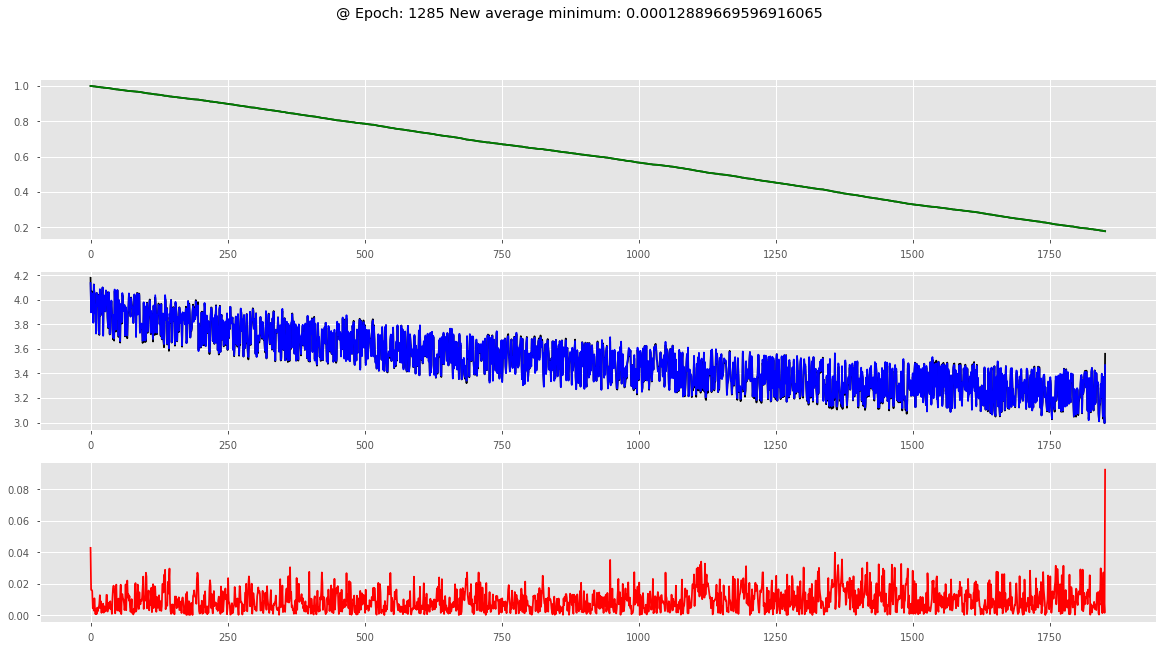

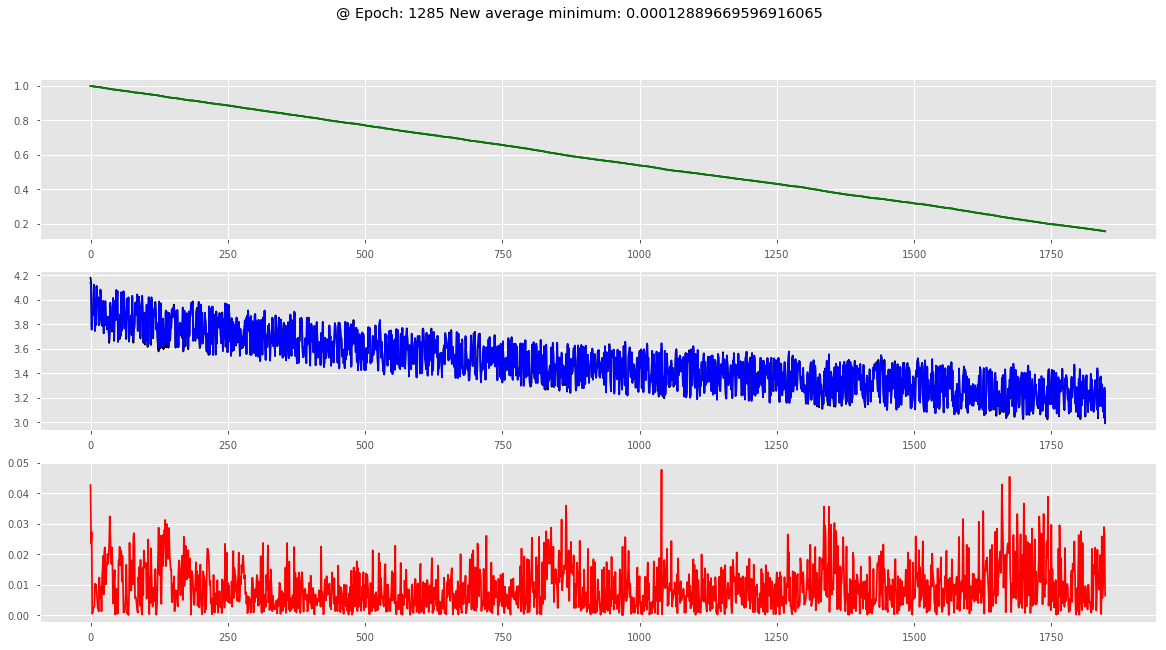

epoch 2000, time since start: 0m 44s, estimated remaining time: 0h 8m 31s


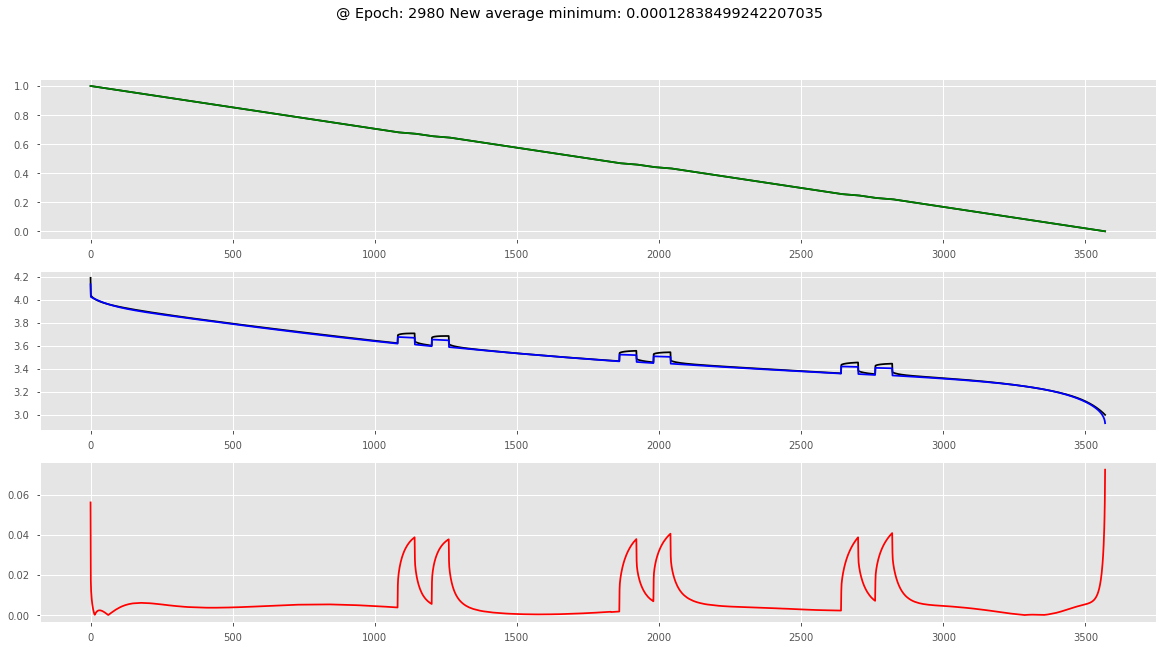

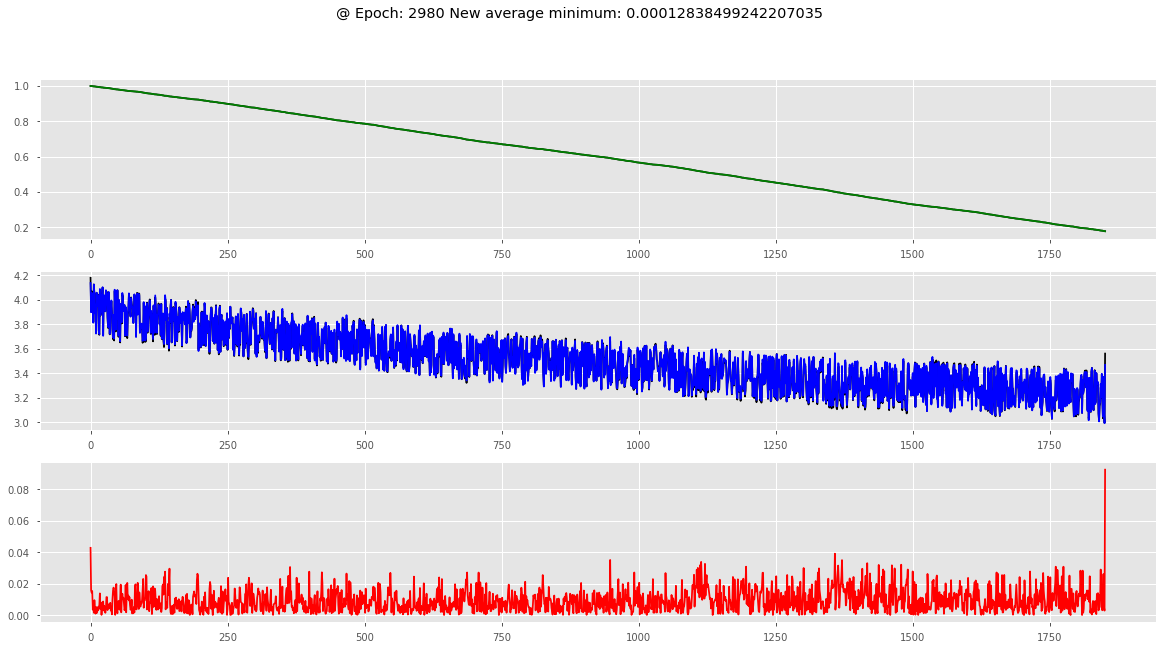

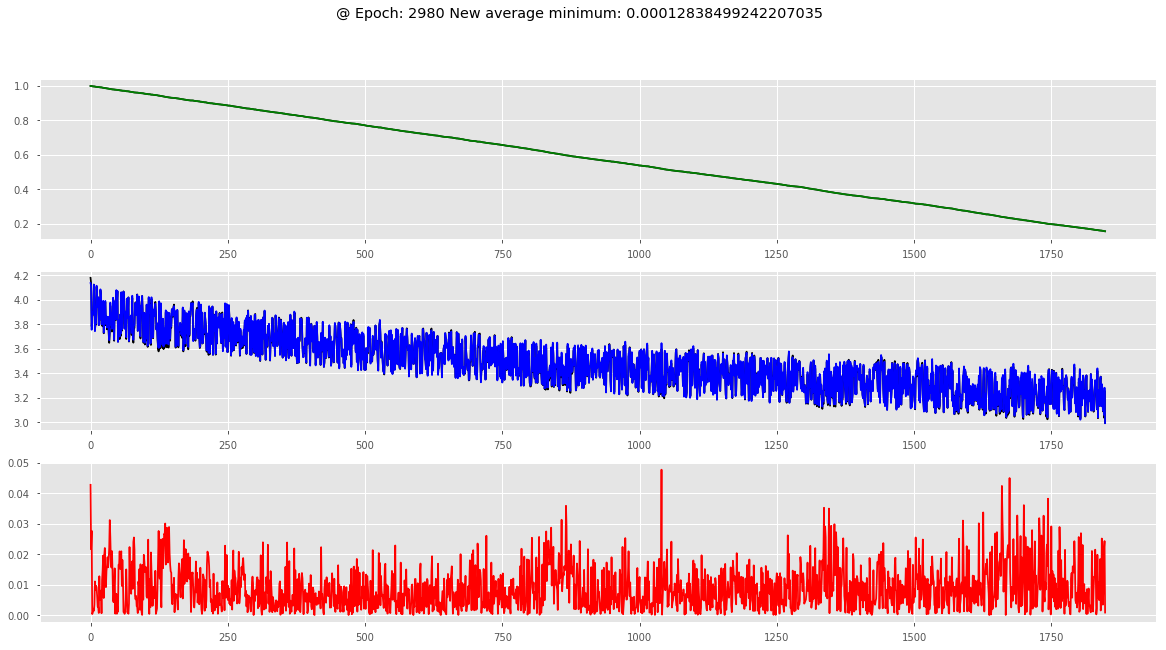

epoch 3000, time since start: 1m 5s, estimated remaining time: 0h 8m 2s
epoch 4000, time since start: 1m 26s, estimated remaining time: 0h 7m 32s


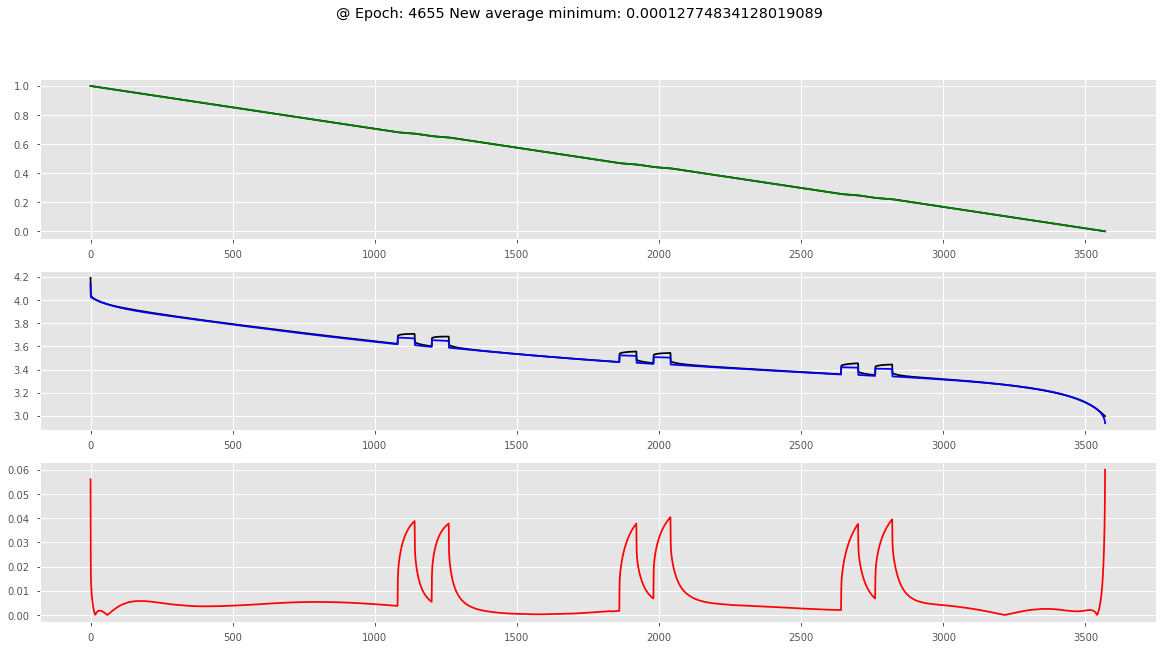

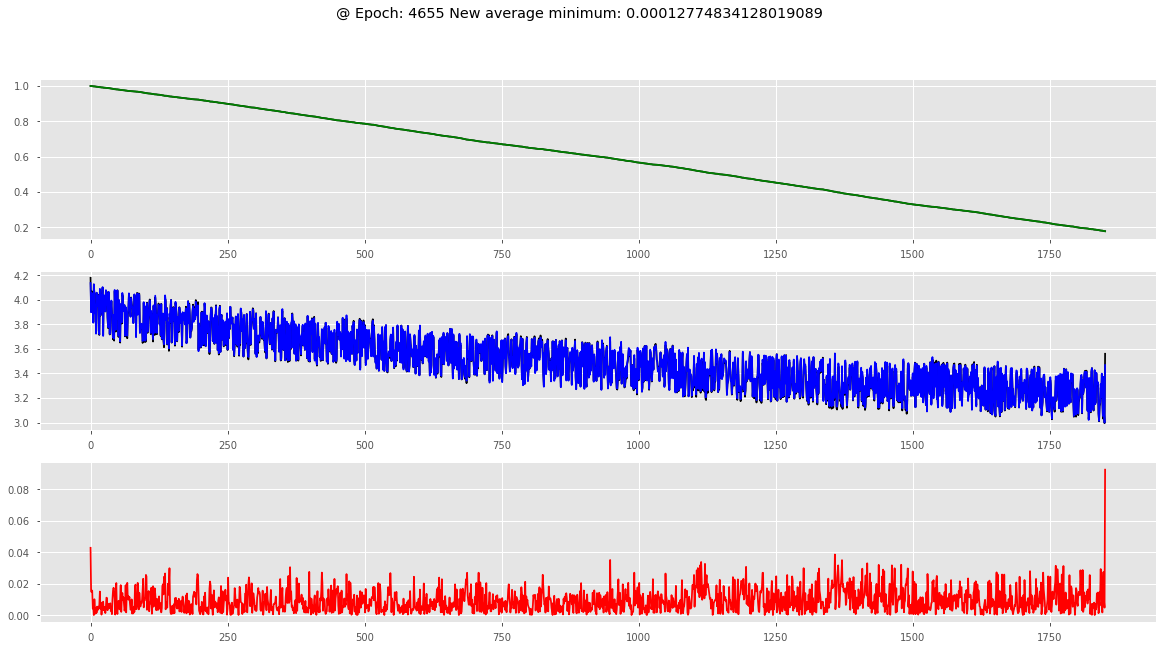

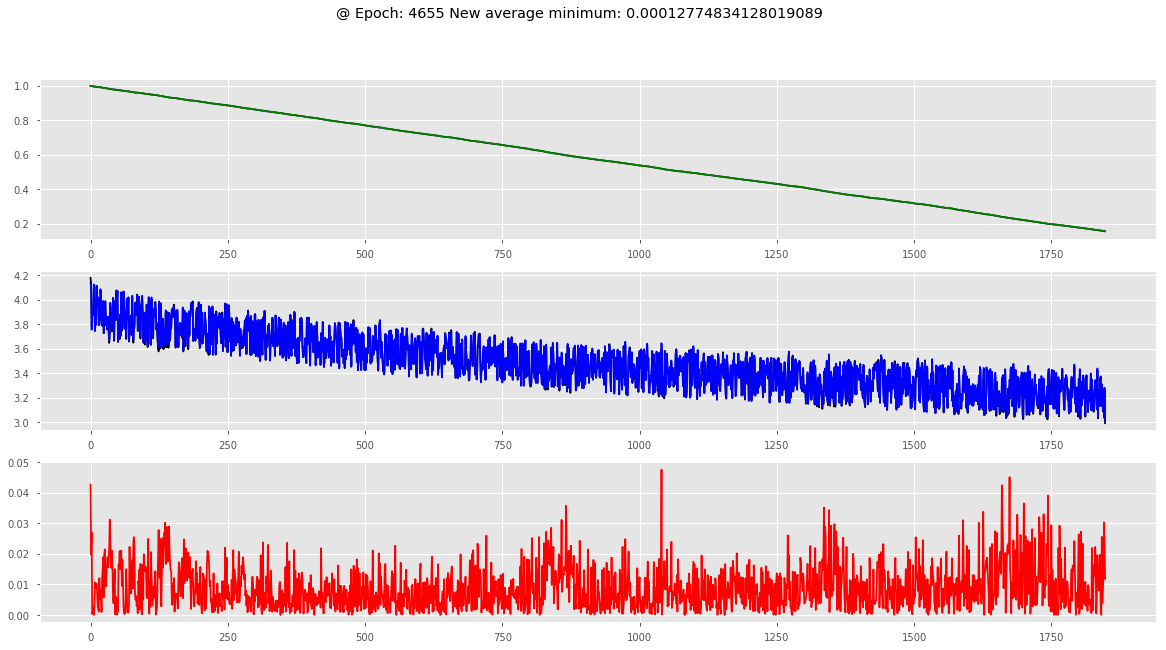

epoch 5000, time since start: 1m 48s, estimated remaining time: 0h 7m 12s


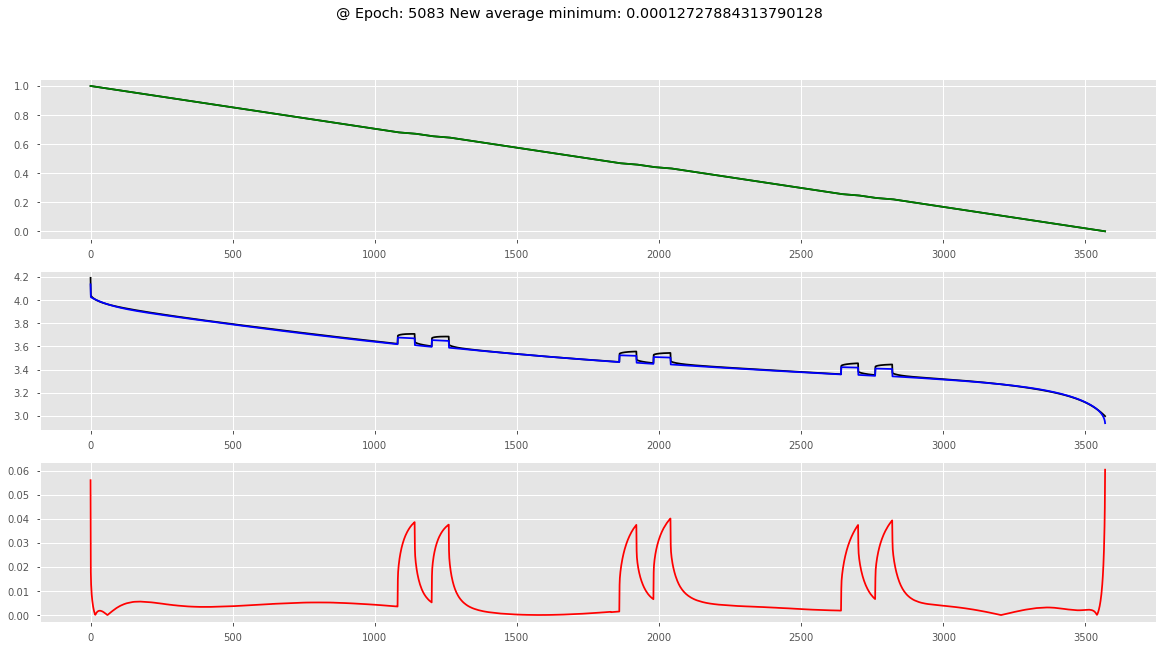

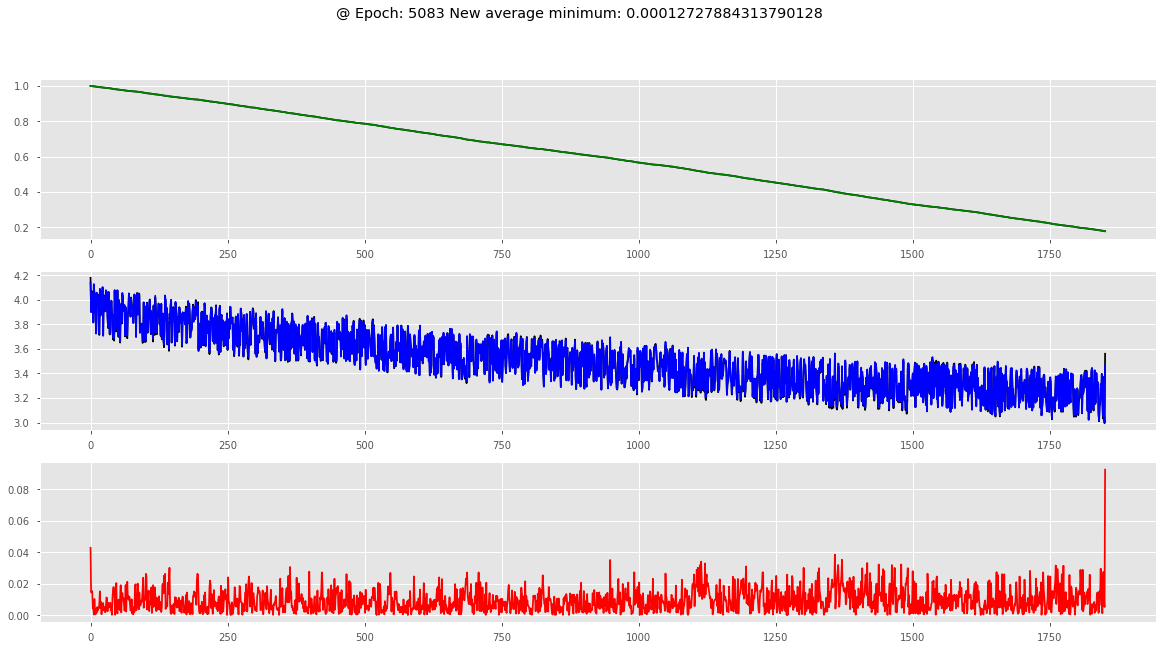

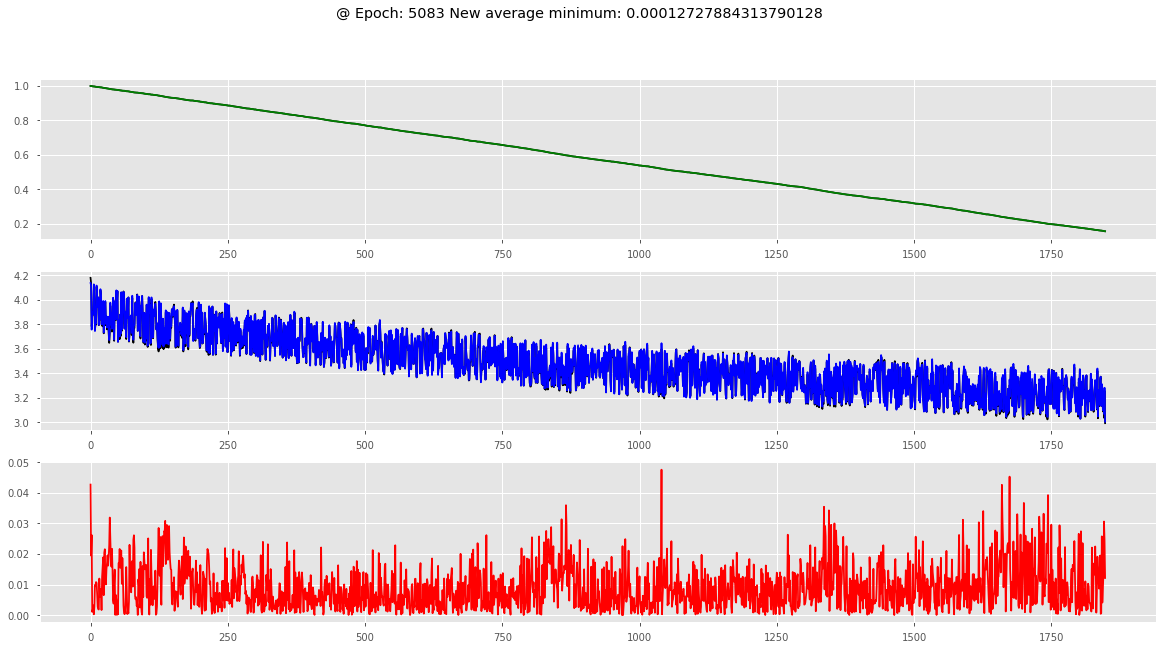

epoch 6000, time since start: 2m 10s, estimated remaining time: 0h 6m 54s


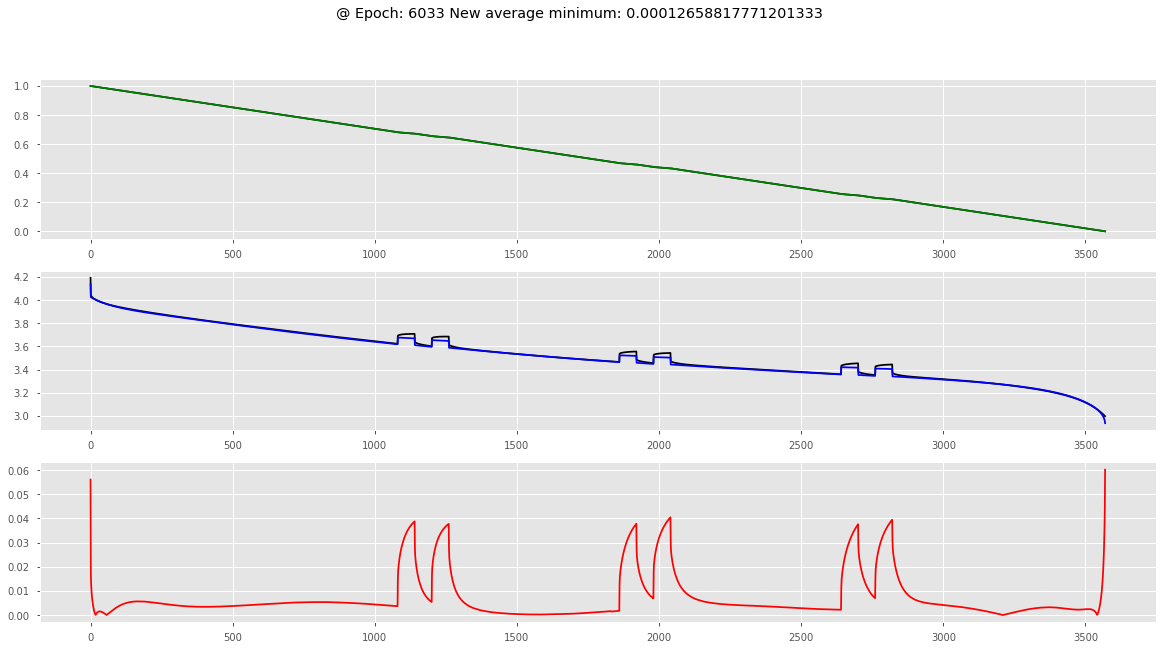

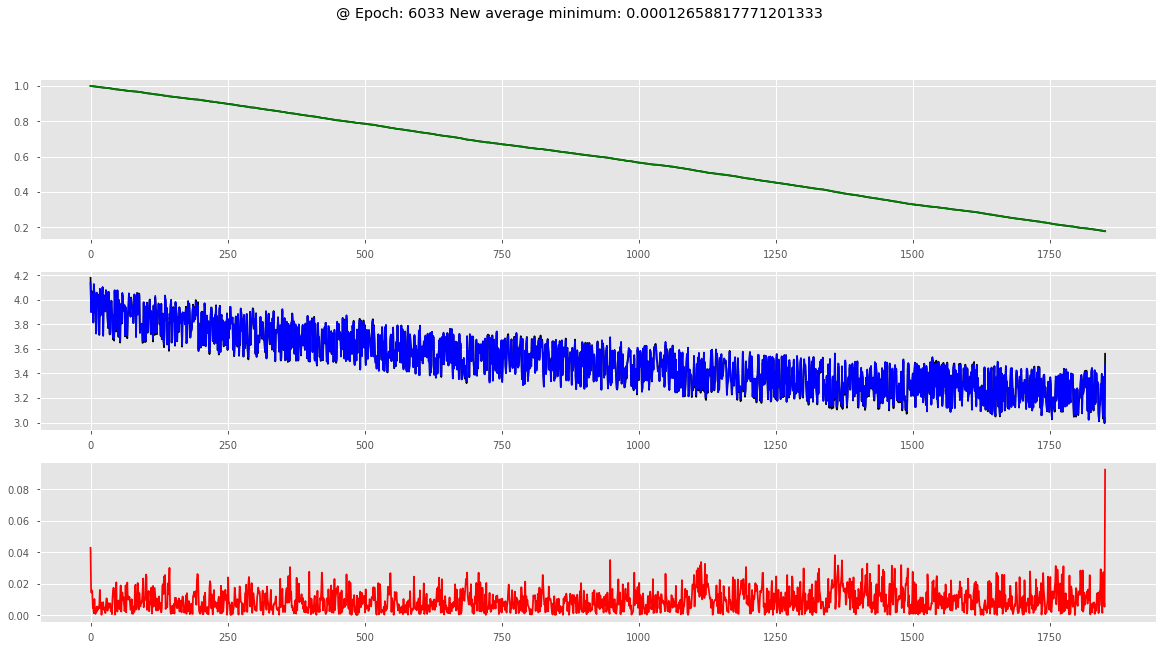

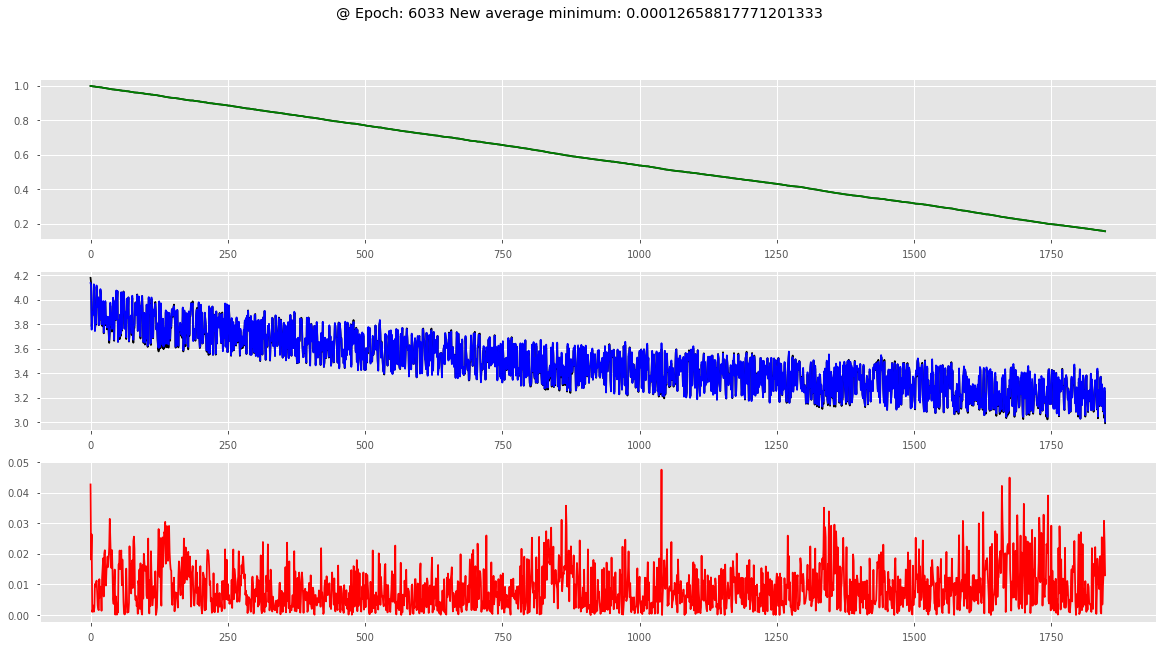

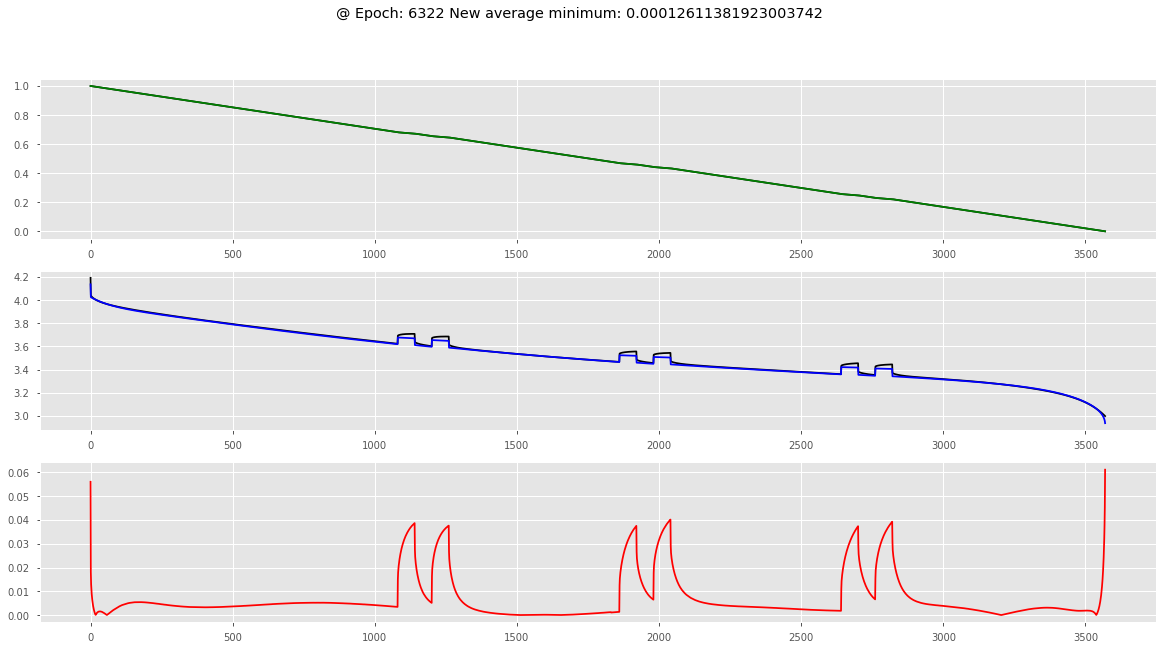

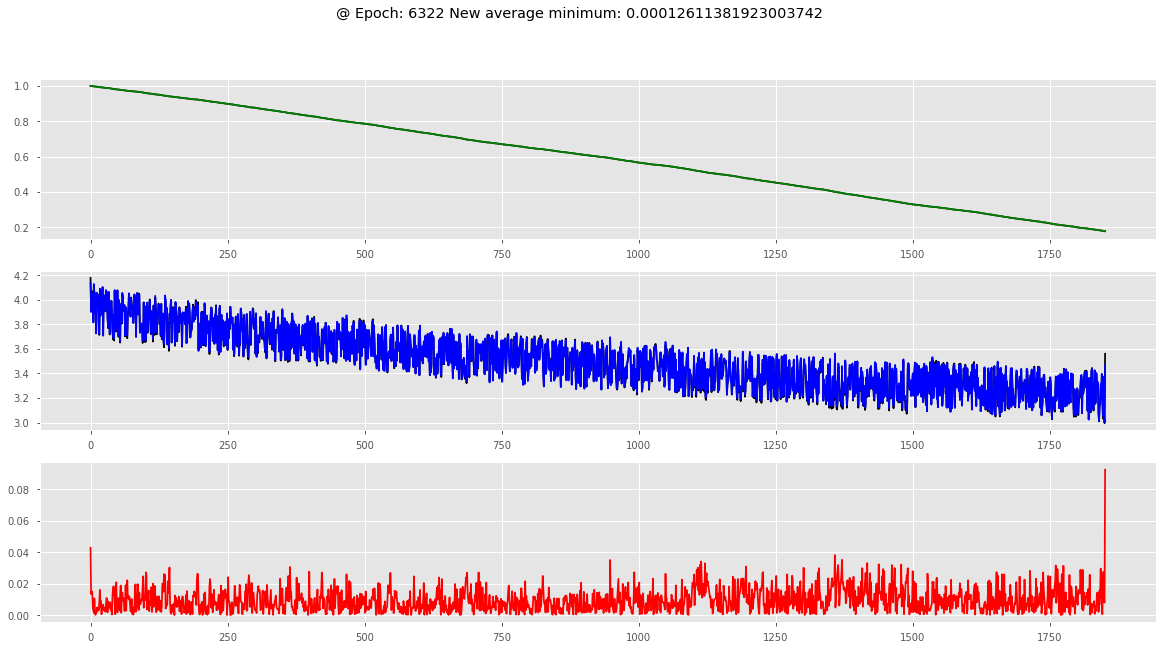

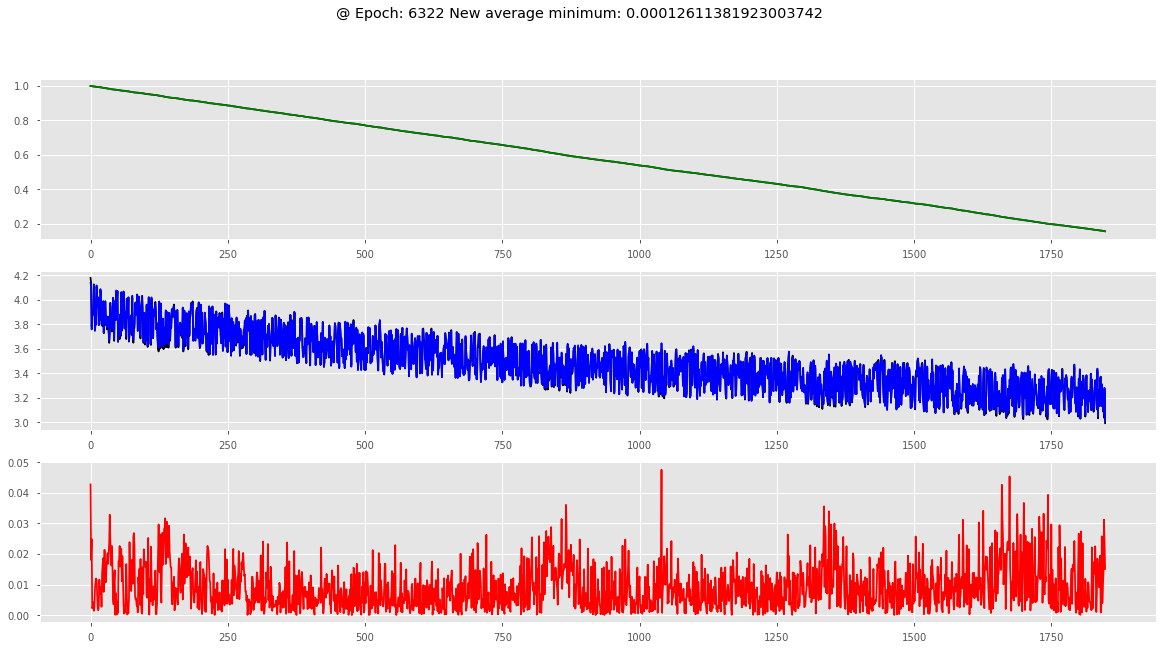

epoch 7000, time since start: 2m 35s, estimated remaining time: 0h 6m 40s
epoch 8000, time since start: 2m 58s, estimated remaining time: 0h 6m 19s


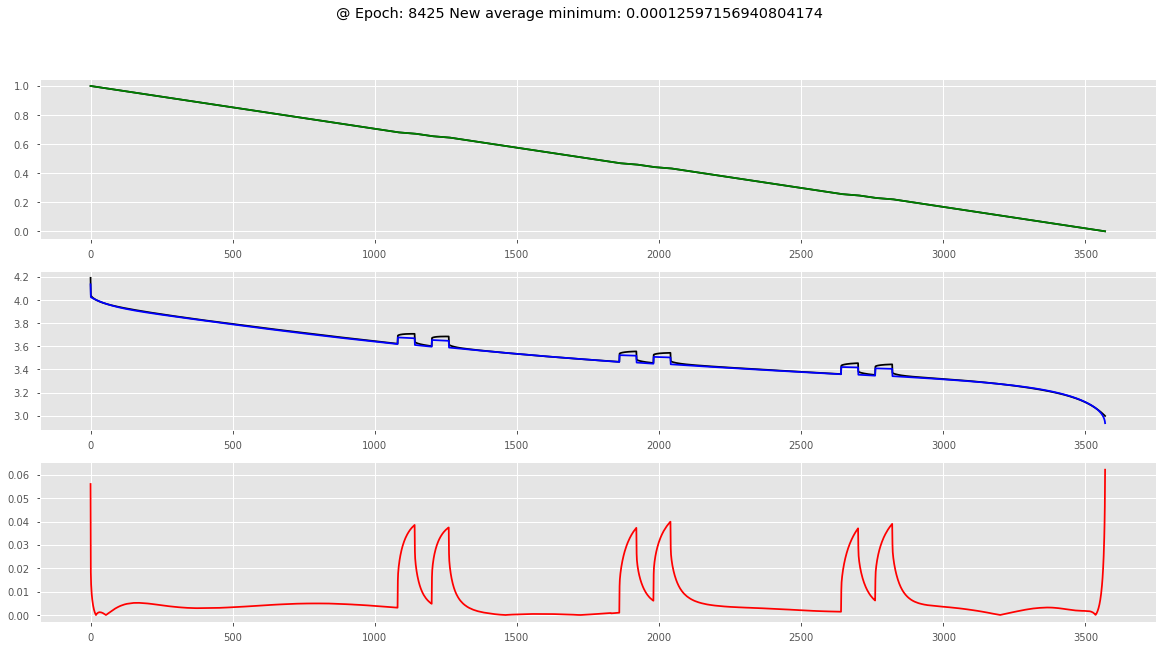

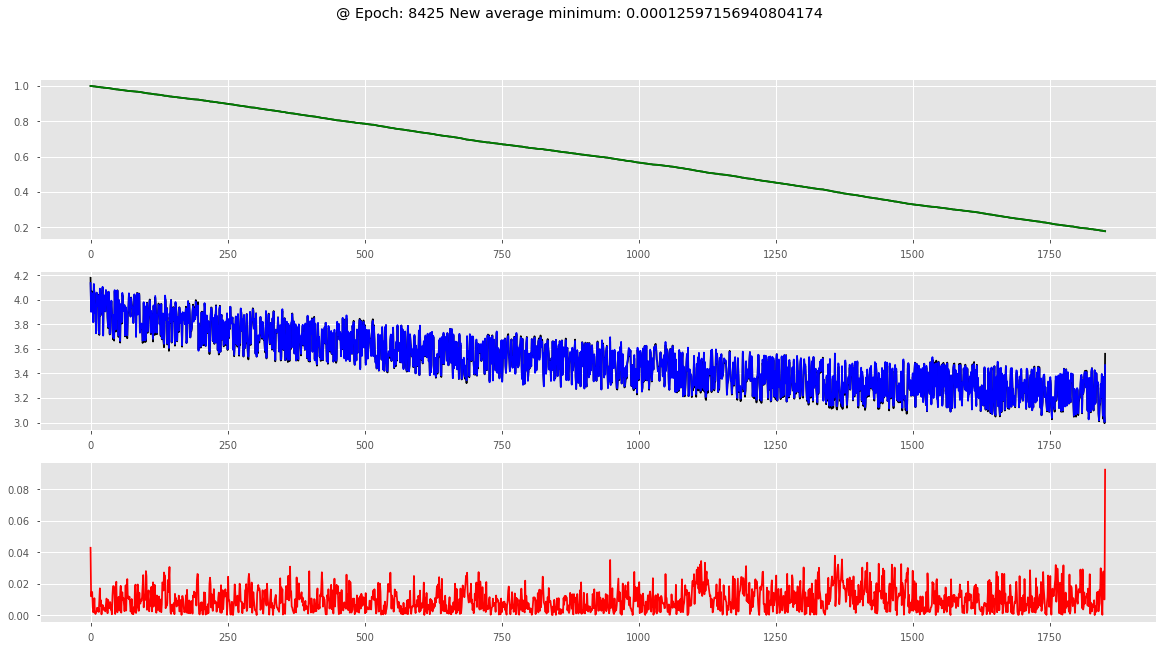

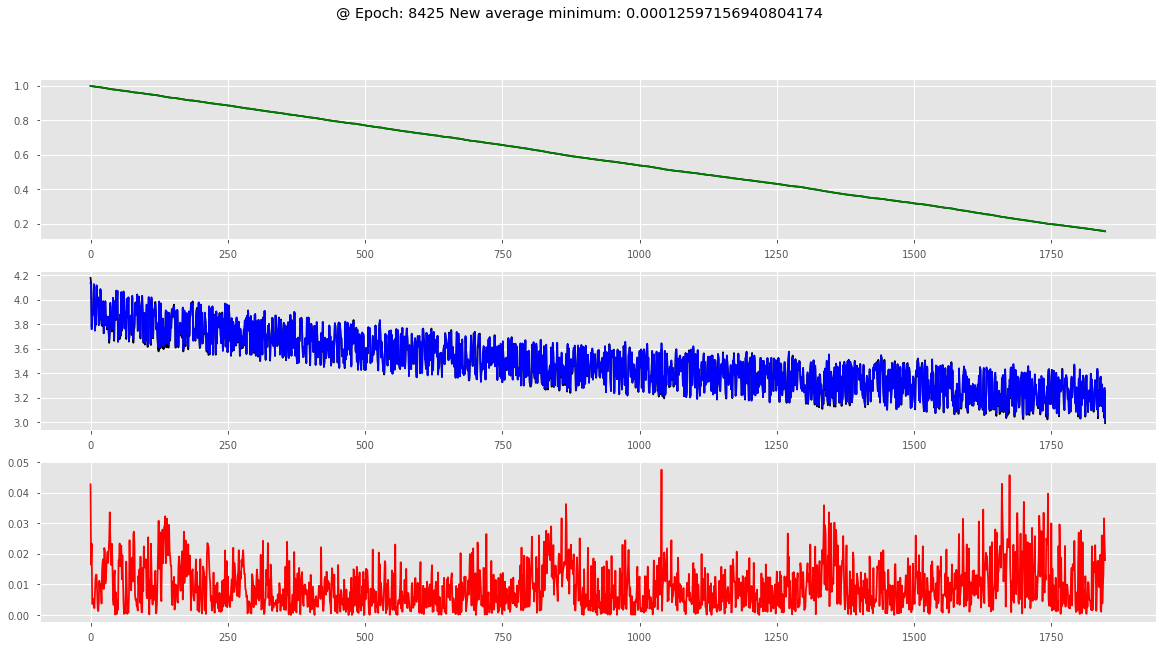

epoch 9000, time since start: 3m 22s, estimated remaining time: 0h 5m 59s
epoch 10000, time since start: 3m 43s, estimated remaining time: 0h 5m 34s


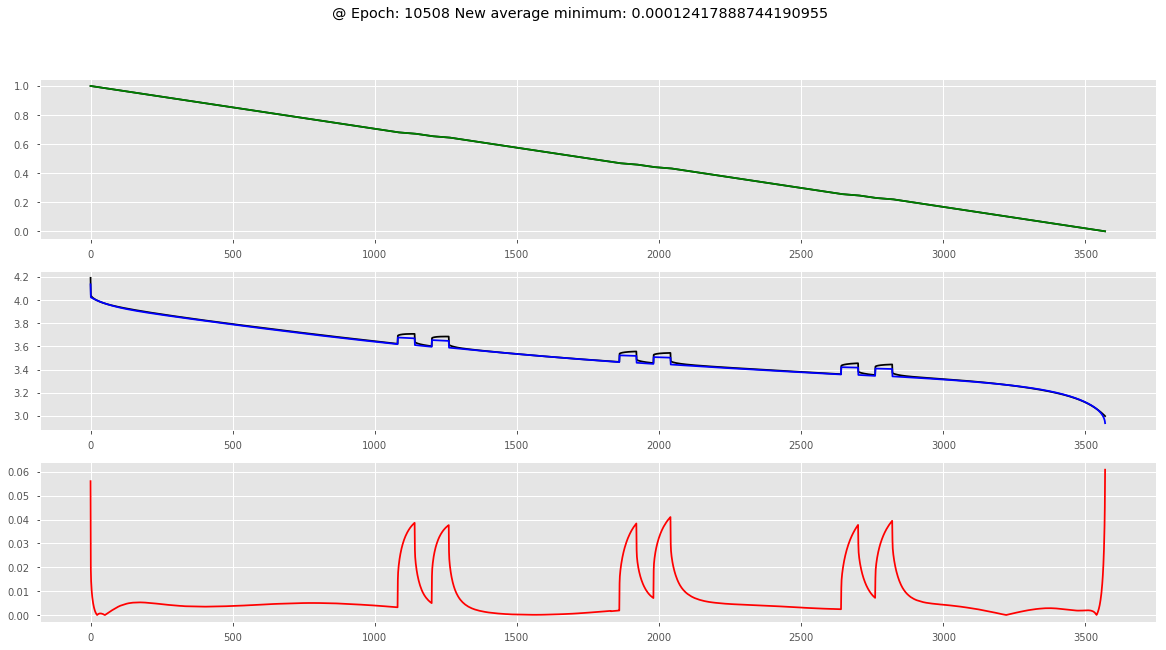

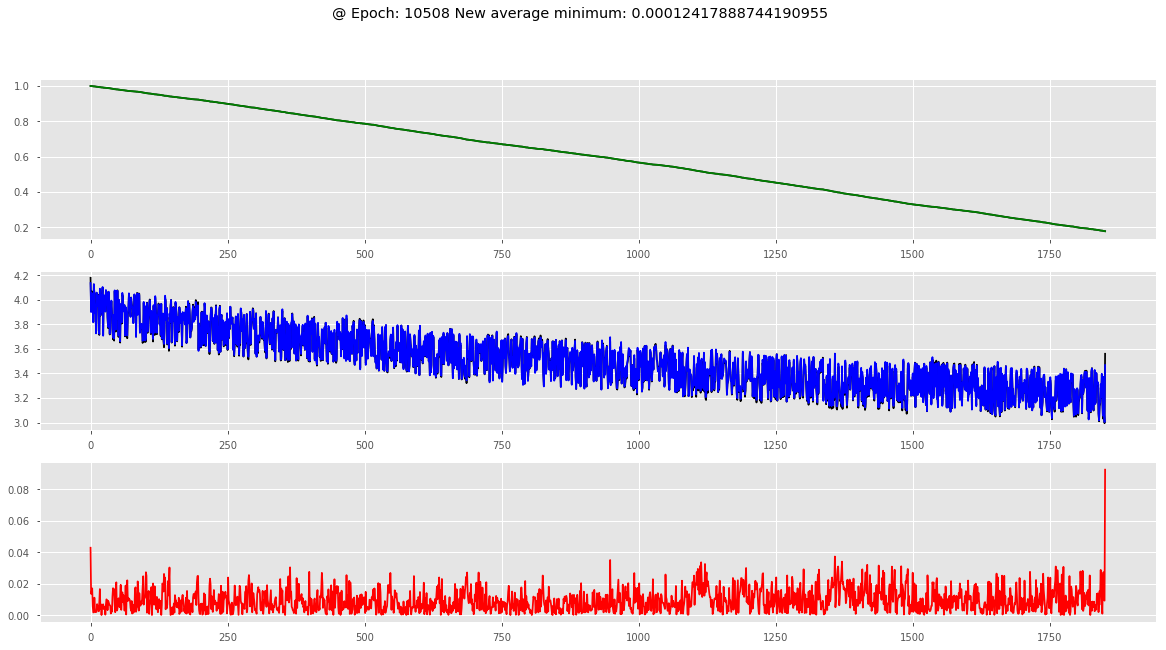

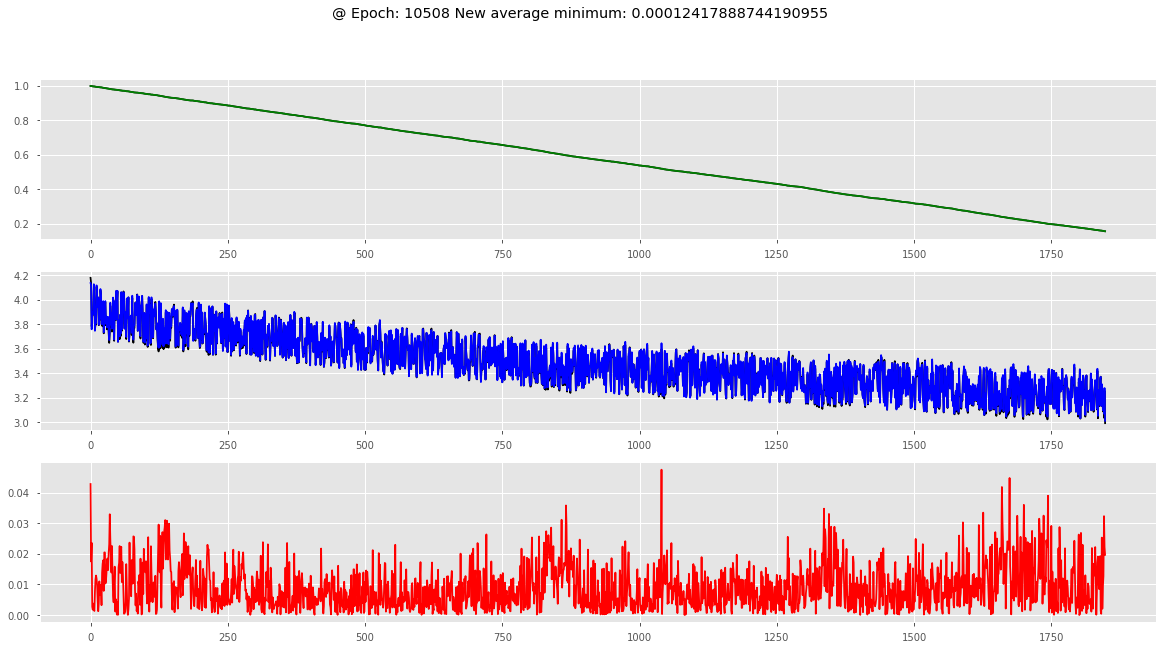

epoch 11000, time since start: 4m 5s, estimated remaining time: 0h 5m 12s
epoch 12000, time since start: 4m 26s, estimated remaining time: 0h 4m 48s
epoch 13000, time since start: 4m 48s, estimated remaining time: 0h 4m 25s
epoch 14000, time since start: 5m 9s, estimated remaining time: 0h 4m 2s


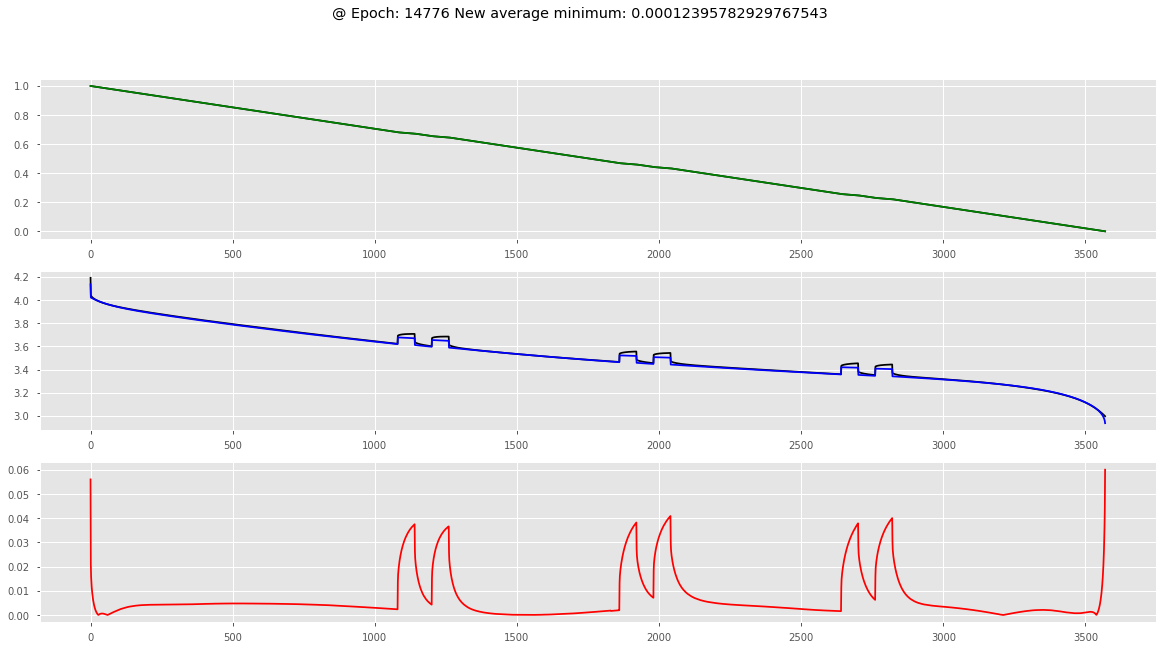

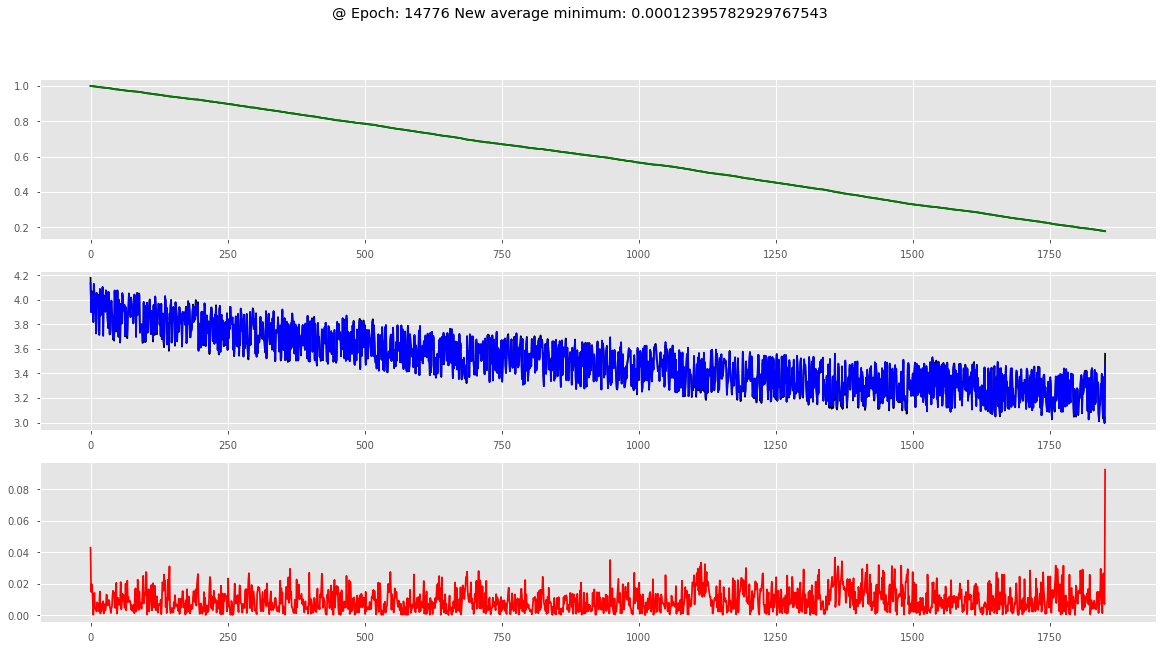

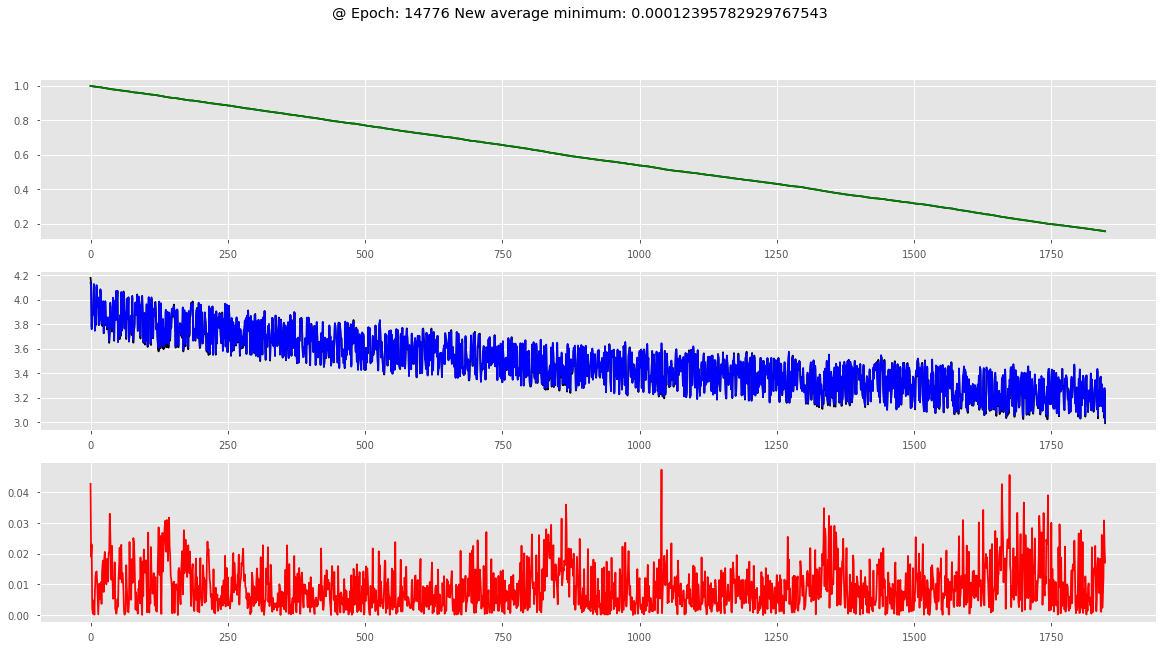

epoch 15000, time since start: 5m 32s, estimated remaining time: 0h 3m 41s
epoch 16000, time since start: 5m 53s, estimated remaining time: 0h 3m 18s
epoch 17000, time since start: 6m 14s, estimated remaining time: 0h 2m 56s
epoch 18000, time since start: 6m 36s, estimated remaining time: 0h 2m 34s
epoch 19000, time since start: 6m 57s, estimated remaining time: 0h 2m 11s
epoch 20000, time since start: 7m 18s, estimated remaining time: 0h 1m 49s
epoch 21000, time since start: 7m 40s, estimated remaining time: 0h 1m 27s
epoch 22000, time since start: 8m 1s, estimated remaining time: 0h 1m 5s


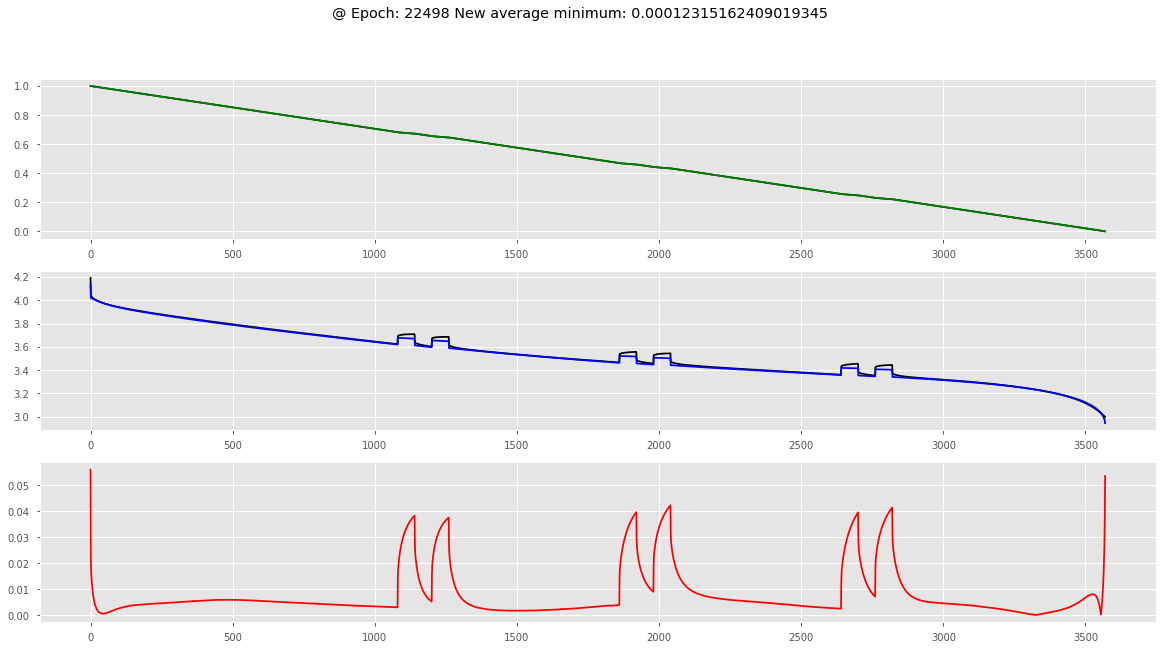

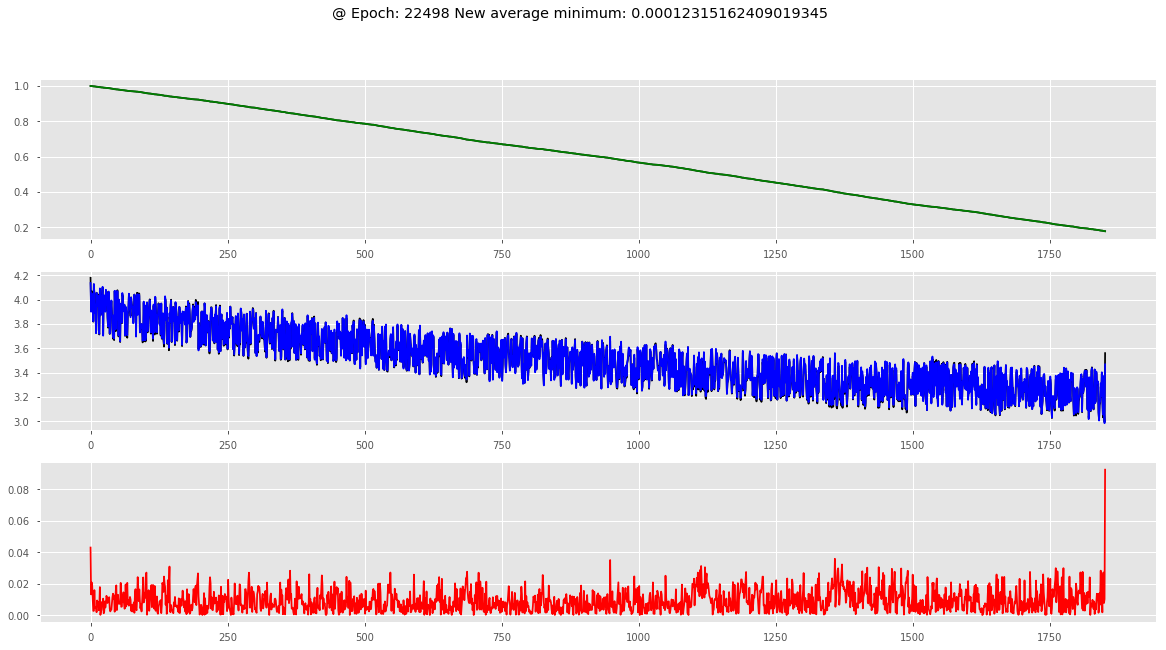

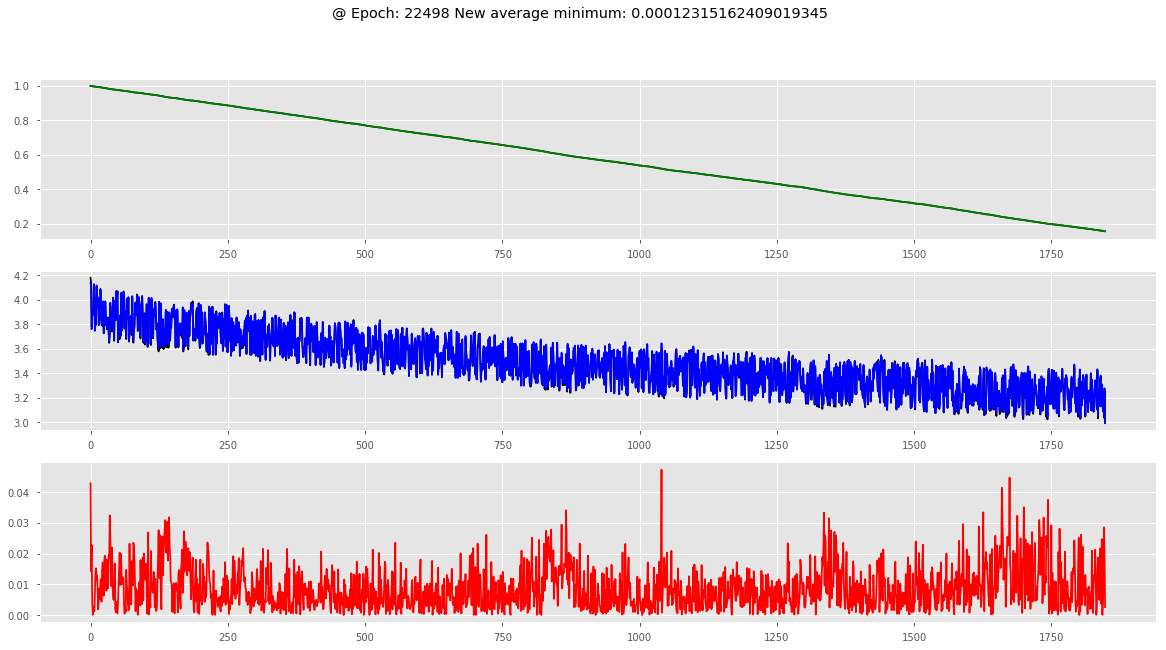

epoch 23000, time since start: 8m 25s, estimated remaining time: 0h 0m 43s
epoch 24000, time since start: 8m 47s, estimated remaining time: 0h 0m 21s


In [18]:
import time
import math

epochs = 50000
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
rnn.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

count_since_plot = 0
for epoch in range(epochs):
    count = -1
    avg_loss = 0
    loss_set_hist = []
    
    for set_dict in Characterisation_Set['Sets']:
        count += 1
        V = torch.from_numpy(set_dict['Voltage'].T).to(device, torch.float)
        optimizer.zero_grad()
        soc_prior = set_dict['SoC_prior'].T
        current_prior = set_dict['Current_prior'].T
        current =  set_dict['Current'].T
        V_est, SoC = rnn(soc_prior, current_prior, current)
        loss = criterion(V_est, V)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        loss_set_hist.append(loss.item())
        if epoch == 0:
            with torch.no_grad():
                V_est, SoC = rnn(soc_prior, current_prior, current)
                plt.figure(count)
                plt.subplot(2,1,1)
                plt.plot(set_dict['SoC'].T, 'k')
                plt.plot(SoC.to("cpu").numpy(), 'g')
                plt.subplot(2,1,2)
                plt.plot(V.to("cpu").numpy(), 'k')
                plt.plot(V_est.to("cpu").numpy(), 'b')
                plt.show()
    loss_hist.append(loss_set_hist)
    avg_loss /= (count+1)
    count_since_plot += 1
    if epoch % 1000 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        torch.save(rnn.state_dict(), save_network)
        loss_min = avg_loss
        if count_since_plot > 250: 
            count_since_plot = 0
            with torch.no_grad():
                for set_dict in Characterisation_Set['Sets']:
                    V = torch.from_numpy(set_dict['Voltage'].T).to(device, torch.float)
                    soc_prior = set_dict['SoC_prior'].T
                    current_prior = set_dict['Current_prior'].T
                    current =  set_dict['Current'].T
                    V_est, SoC = rnn(soc_prior, current_prior, current)
                    plt.figure(count)
                    plt.suptitle("@ Epoch: {} New average minimum: {}".format(epoch, avg_loss))
                    plt.subplot(3,1,1)
                    plt.plot(set_dict['SoC'].T, 'k')
                    plt.plot(SoC.to("cpu").numpy(), 'g')
                    plt.subplot(3,1,2)
                    plt.plot(V.to("cpu").numpy(), 'k')
                    plt.plot(V_est.to("cpu").numpy(), 'b')
                    plt.subplot(3,1,3)
                    plt.plot(np.abs(V.to("cpu").numpy() - V_est.to("cpu").numpy()), 'r')
                    plt.show()
        else:
            print("New average minimum: " + str(avg_loss))

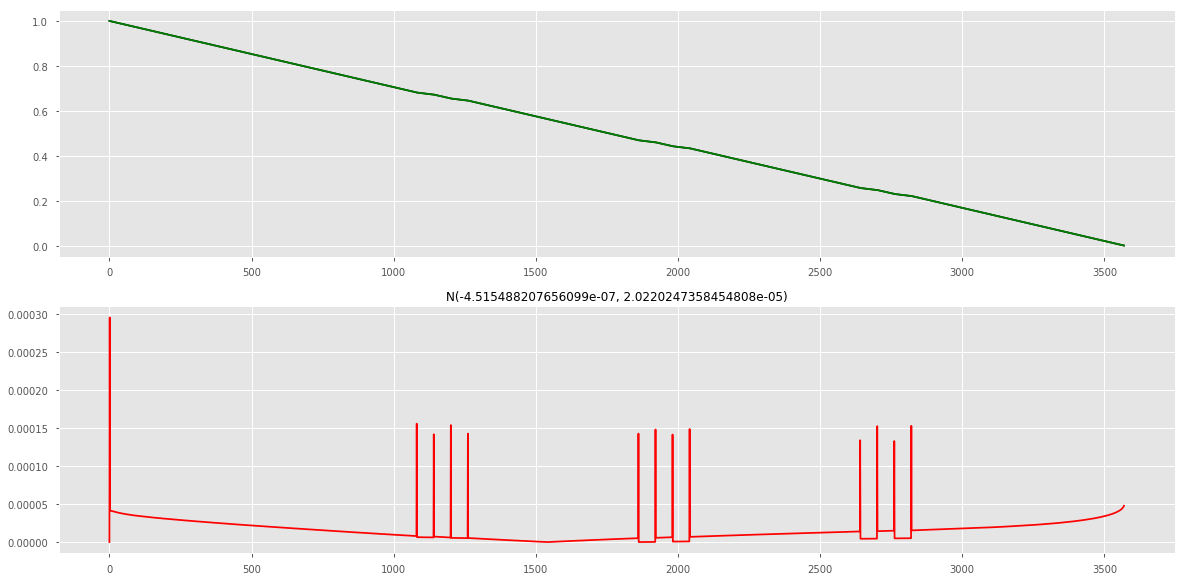

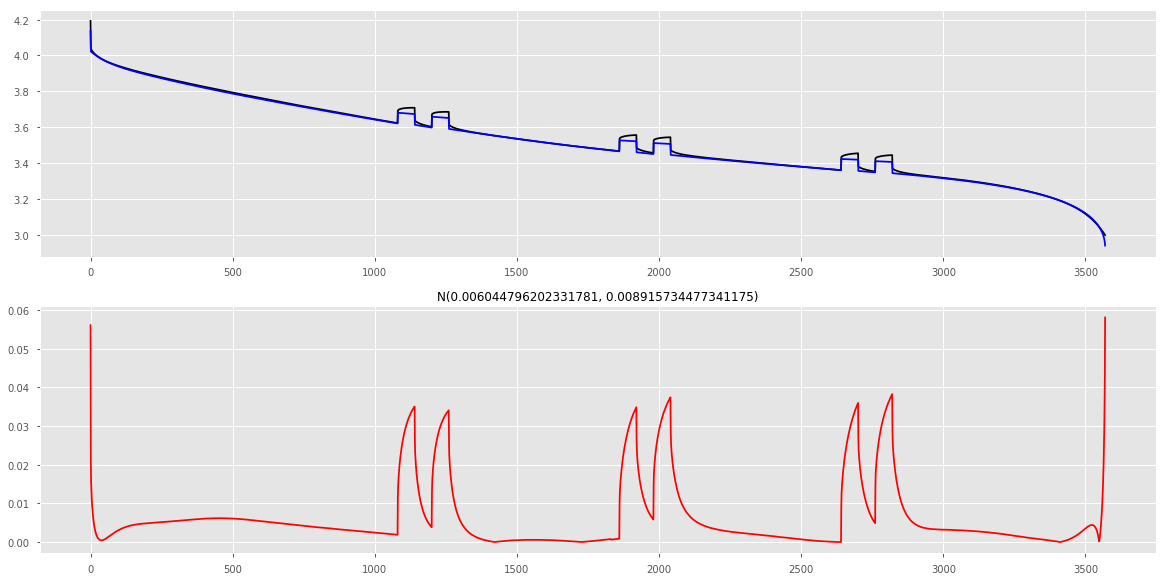

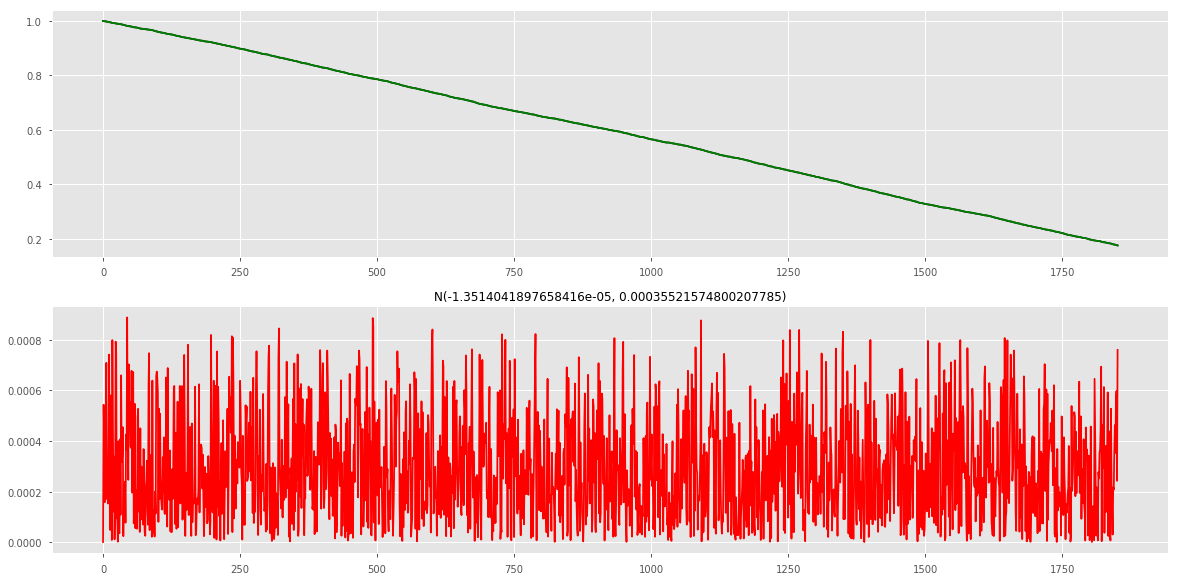

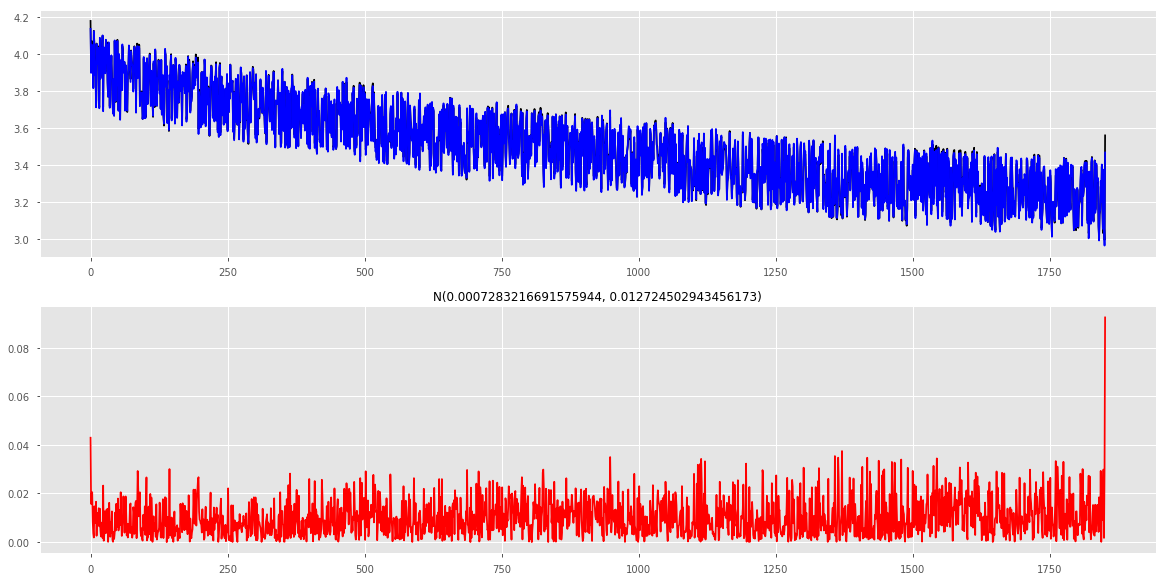

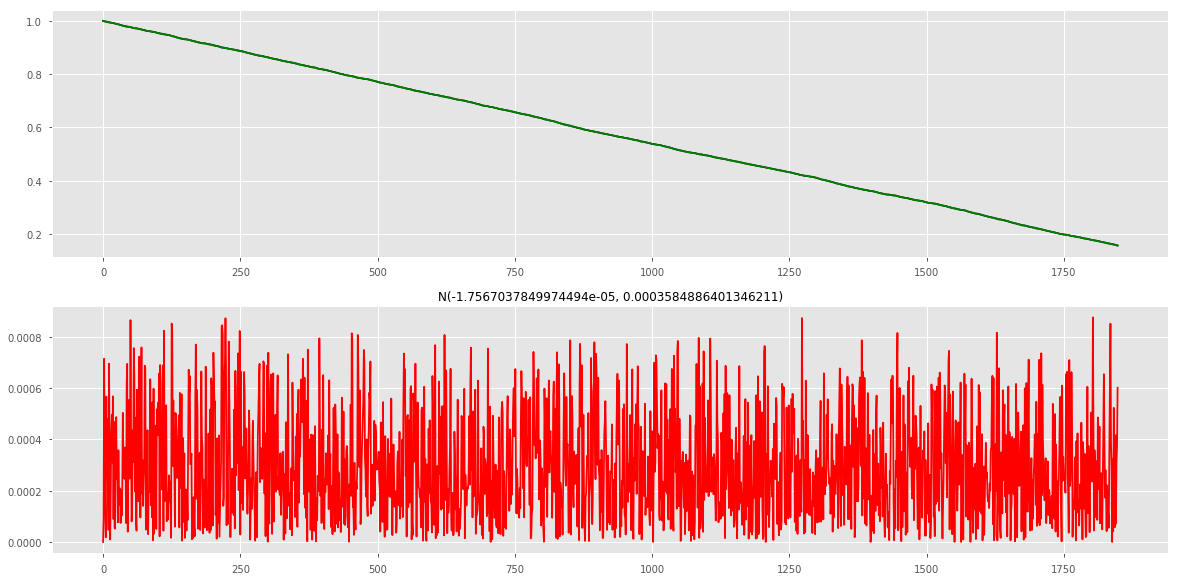

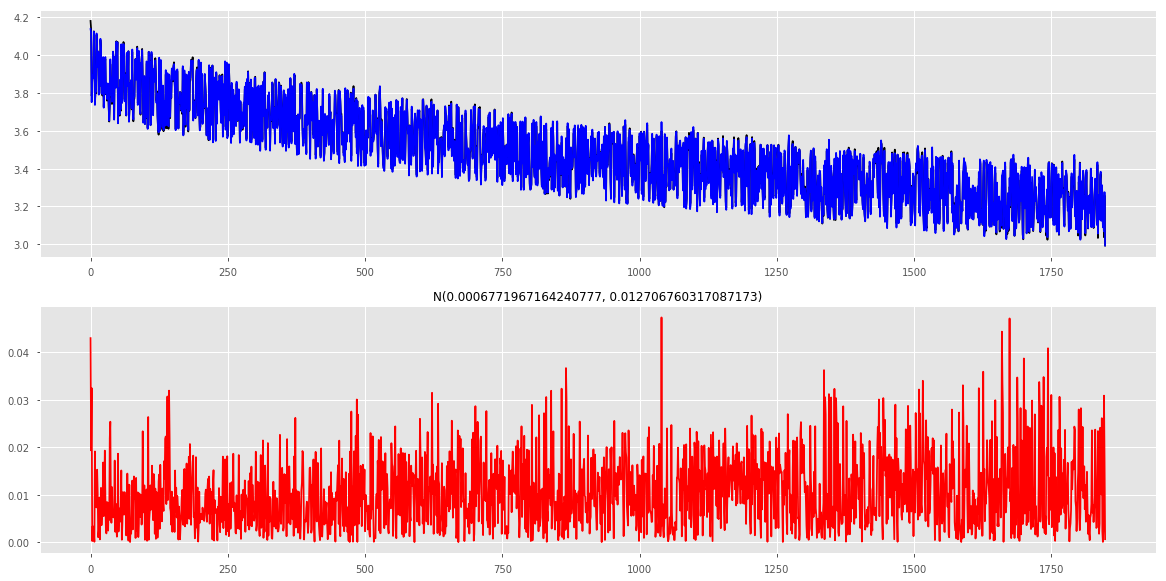

SoC mean: -8.131135726750027e-06
SoC std: 0.0002551068601502507
Voltage mean: 0.0033256651
Voltage std: 0.011334095


In [26]:
accumulate_soc_error = []
accumate_v_error = []
with torch.no_grad():
    for set_dict in Characterisation_Set['Sets']:
        V = torch.from_numpy(set_dict['Voltage'].T).to(device, torch.float)
        soc_prior = set_dict['SoC_prior'].T
        current_prior = set_dict['Current_prior'].T
        current =  set_dict['Current'].T
        V_est, SoC = rnn(soc_prior, current_prior, current)
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(set_dict['SoC'].T, 'k')
        plt.plot(SoC.to("cpu").numpy(), 'g')
        plt.subplot(2,1,2)
        error = set_dict['SoC'].T - SoC.to("cpu").numpy()
        accumulate_soc_error.append(error)
        soc_mean_error = np.mean(error)
        soc_std_error = np.std(error)
        plt.title("N({}, {})".format(soc_mean_error, soc_std_error))
        plt.plot(np.abs(set_dict['SoC'].T - SoC.to("cpu").numpy()), 'r')
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(V.to("cpu").numpy(), 'k')
        plt.plot(V_est.to("cpu").numpy(), 'b')
        plt.subplot(2,1,2)
        error = V.to("cpu").numpy() - V_est.to("cpu").numpy()
        accumate_v_error.append(error)
        voltage_mean_error = np.mean(error)
        voltage_std_error = np.std(error)
        plt.title("N({}, {})".format(voltage_mean_error, voltage_std_error))
        plt.plot(np.abs(V.to("cpu").numpy() - V_est.to("cpu").numpy()), 'r')
plt.show()
soc_error = np.concatenate(accumulate_soc_error)
soc_mean = np.mean(soc_error)
print("SoC mean:", soc_mean)
soc_std = np.std(soc_error)
print("SoC std:", soc_std)
v_error = np.concatenate(accumate_v_error)
v_mean = np.mean(v_error)
print("Voltage mean:", v_mean)
v_std = np.std(v_error)
print("Voltage std:", v_std)

In [27]:
class Polarising_Impedance_Map(nn.Module):
    def __init__(self):
        super(Polarising_Impedance_Map, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)

    def forward(self, soc_prior, current_prior):
        
        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        return Z

In [28]:
Z_pol = Polarising_Impedance_Map()
Z_pol.load_state_dict(torch.load(save_network))
Z_pol.to(device)

Polarising_Impedance_Map(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
)

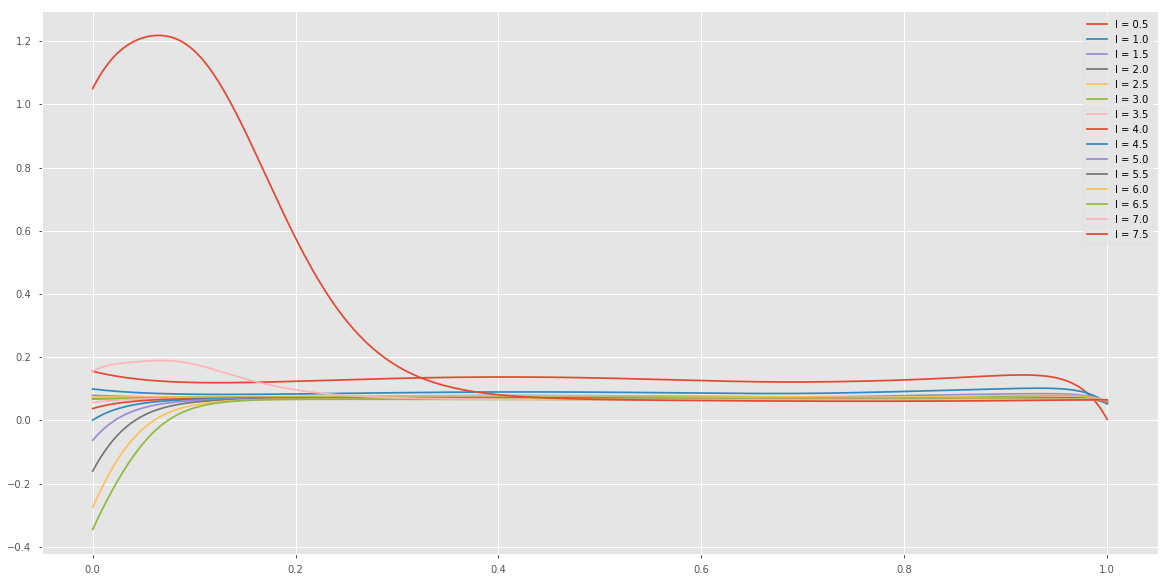

In [45]:
soc_map = np.array(np.linspace(0, 1.0, 1000), ndmin=2)
Z_map = []
plt.figure()
for i in range(1, 16):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*float(i/2.0))
        Z_map.append(Z.cpu().numpy())
#         plt.subplot(2, 1, 1)
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i/2.0))
#         plt.subplot(2, 1, 2)
#         plt.semilogy(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i))
# plt.axis([-0.1, 1.1, 0.0, 0.1])
plt.legend()
plt.show()

(100, 1000)


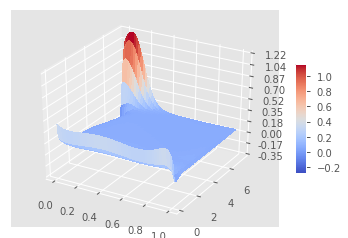

In [61]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = soc_map
Y = np.linspace(0.1, 7.5, 100)
Z_surf = []
for i in range(Y.shape[0]):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*Y[i])
        Z_surf.append(Z.cpu().numpy())
X, Y = np.meshgrid(X, Y)
Z = np.concatenate(Z_surf, axis=1).T
print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()